## Data exploration

This script performs some data exploration to see, what kind of data our data set contains.

In [1]:
import pandas as pd
import pathlib

from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


import os
import sys
sys.path.append(os.path.abspath('configs'))
from config import *

path = pathlib.Path.cwd()
data_path = path / "CompiledDataSet" / "Cassini_CDA_Count+Event_V0.csv"

df = pd.read_csv(data_path, index_col=0, parse_dates=["TIME"])
df.head()

C:\Users\jerem\AppData\Local\Temp\ipykernel_15488\3024008631.py:18: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, index_col=0, parse_dates=["TIME"])


TIME  COUNTER_0  COUNTER_1  COUNTER_2  COUNTER_3  COUNTER_4  \
0 2005-01-01 00:00:34        2.0       16.0       12.0       71.0      246.0   
1 2005-01-01 00:01:38        2.0       16.0       12.0       71.0      246.0   
2 2005-01-01 00:02:42        2.0       16.0       12.0       71.0      246.0   
3 2005-01-01 00:03:46        2.0       16.0       12.0       71.0      246.0   
4 2005-01-01 00:04:50        2.0       16.0       12.0       71.0      246.0   

   COUNTER_5  COUNTER_6  COUNTER_7  COUNTER_8  ...  DETECTOR_DEC  \
0      186.0       25.0       14.0        0.0  ...         59.25   
1      189.0       25.0       14.0        0.0  ...         59.25   
2      191.0       25.0       14.0        0.0  ...         59.25   
3      192.0       25.0       14.0        0.0  ...         59.25   
4      193.0       25.0       14.0        0.0  ...         59.23   

   COUNTER_NUMBER  EVENT_QUALITY  PARTICLE_SPEED  PARTICLE_SPEED_FACTOR  \
0              37            NaN             NaN                    NaN   
1              37            NaN             NaN                    NaN   
2              37            NaN             NaN                    NaN   
3              37            NaN             NaN                    NaN   
4              19            NaN             NaN                    NaN   

   PARTICLE_MASS  PARTICLE_MASS_FACTOR  PARTICLE_CHARGE  \
0            NaN                   NaN              NaN   
1            NaN                   NaN              NaN   
2            NaN                   NaN              NaN   
3            NaN                   NaN              NaN   
4            NaN                   NaN              NaN   

   PARTICLE_CHARGE_ERROR  SPECTRUM_FLAG  
0                    NaN            0.0  
1                    NaN            0.0  
2                    NaN            0.0  
3                    NaN            0.0  
4                    NaN            0.0  

[5 rows x 57 columns]

In [2]:
#df.info()

In [3]:
# Drop empty or irrelevant columns
drop = [
    "EVENT_QUALITY",
    "PARTICLE_SPEED",
    "PARTICLE_SPEED_FACTOR",
    "PARTICLE_MASS",
    "PARTICLE_MASS_FACTOR",
    "PARTICLE_CHARGE",
    "PARTICLE_CHARGE_ERROR",
    "EVENT_JULIAN_DATE", 
    "COUNTER_NUMBER", 
    "SPECTRUM_FLAG",
    "TARGET_FLAG",
    "QP_SIGNAL_FLAG",
    "QI_SIGNAL_FLAG",
    "QT_SIGNAL_FLAG",
    "QC_SIGNAL_FLAG",
    "EVENT_ID"
]
df = df.drop(columns=drop)
df.to_csv("CompiledDataSet/Cassini_CDA_Count+Event_V1.csv", index=True)

df.head()

TIME  COUNTER_0  COUNTER_1  COUNTER_2  COUNTER_3  COUNTER_4  \
0 2005-01-01 00:00:34        2.0       16.0       12.0       71.0      246.0   
1 2005-01-01 00:01:38        2.0       16.0       12.0       71.0      246.0   
2 2005-01-01 00:02:42        2.0       16.0       12.0       71.0      246.0   
3 2005-01-01 00:03:46        2.0       16.0       12.0       71.0      246.0   
4 2005-01-01 00:04:50        2.0       16.0       12.0       71.0      246.0   

   COUNTER_5  COUNTER_6  COUNTER_7  COUNTER_8  ...  SPACECRAFT_DEC  \
0      186.0       25.0       14.0        0.0  ...           21.44   
1      189.0       25.0       14.0        0.0  ...           21.44   
2      191.0       25.0       14.0        0.0  ...           21.44   
3      192.0       25.0       14.0        0.0  ...           21.44   
4      193.0       25.0       14.0        0.0  ...           21.44   

   SC_SUN_DIST  SC_SIII_LONG  SC_SIII_LAT  SC_SAT_DIST  SC_X_VEL  SC_Y_VEL  \
0       9.0501        223.44        12.46        59.63     -8.38     -4.45   
1       9.0501        223.44        12.46        59.63     -8.38     -4.45   
2       9.0501        223.44        12.46        59.63     -8.38     -4.45   
3       9.0501        223.44        12.46        59.63     -8.38     -4.45   
4       9.0501        223.44        12.46        59.63     -8.38     -4.45   

   SC_Z_VEL  DETECTOR_RA  DETECTOR_DEC  
0     -1.08        67.33         59.25  
1     -1.08        67.33         59.25  
2     -1.08        67.33         59.25  
3     -1.08        67.33         59.25  
4     -1.08        67.60         59.23  

[5 rows x 41 columns]

In [4]:
# calculate counter rates instead of cumulative counters
counter_cols = [col for col in df.columns if col.startswith("COUNTER_")]
df['TIME'] = pd.to_datetime(df['TIME'], errors='coerce')
delta_time = df['TIME'].diff().dt.total_seconds()
diffs = df[counter_cols].diff()

# Flag and mask resets (negative jumps)
reset_mask = (diffs < 0).any(axis=1)
diffs[reset_mask] = np.nan

# Normalize by time interval (event rate)
rate_df = diffs.divide(delta_time, axis=0)
rate_df = rate_df.replace([np.inf, -np.inf], np.nan).fillna(0)

# Overwrite cumulative columns with rate values
df[counter_cols] = rate_df

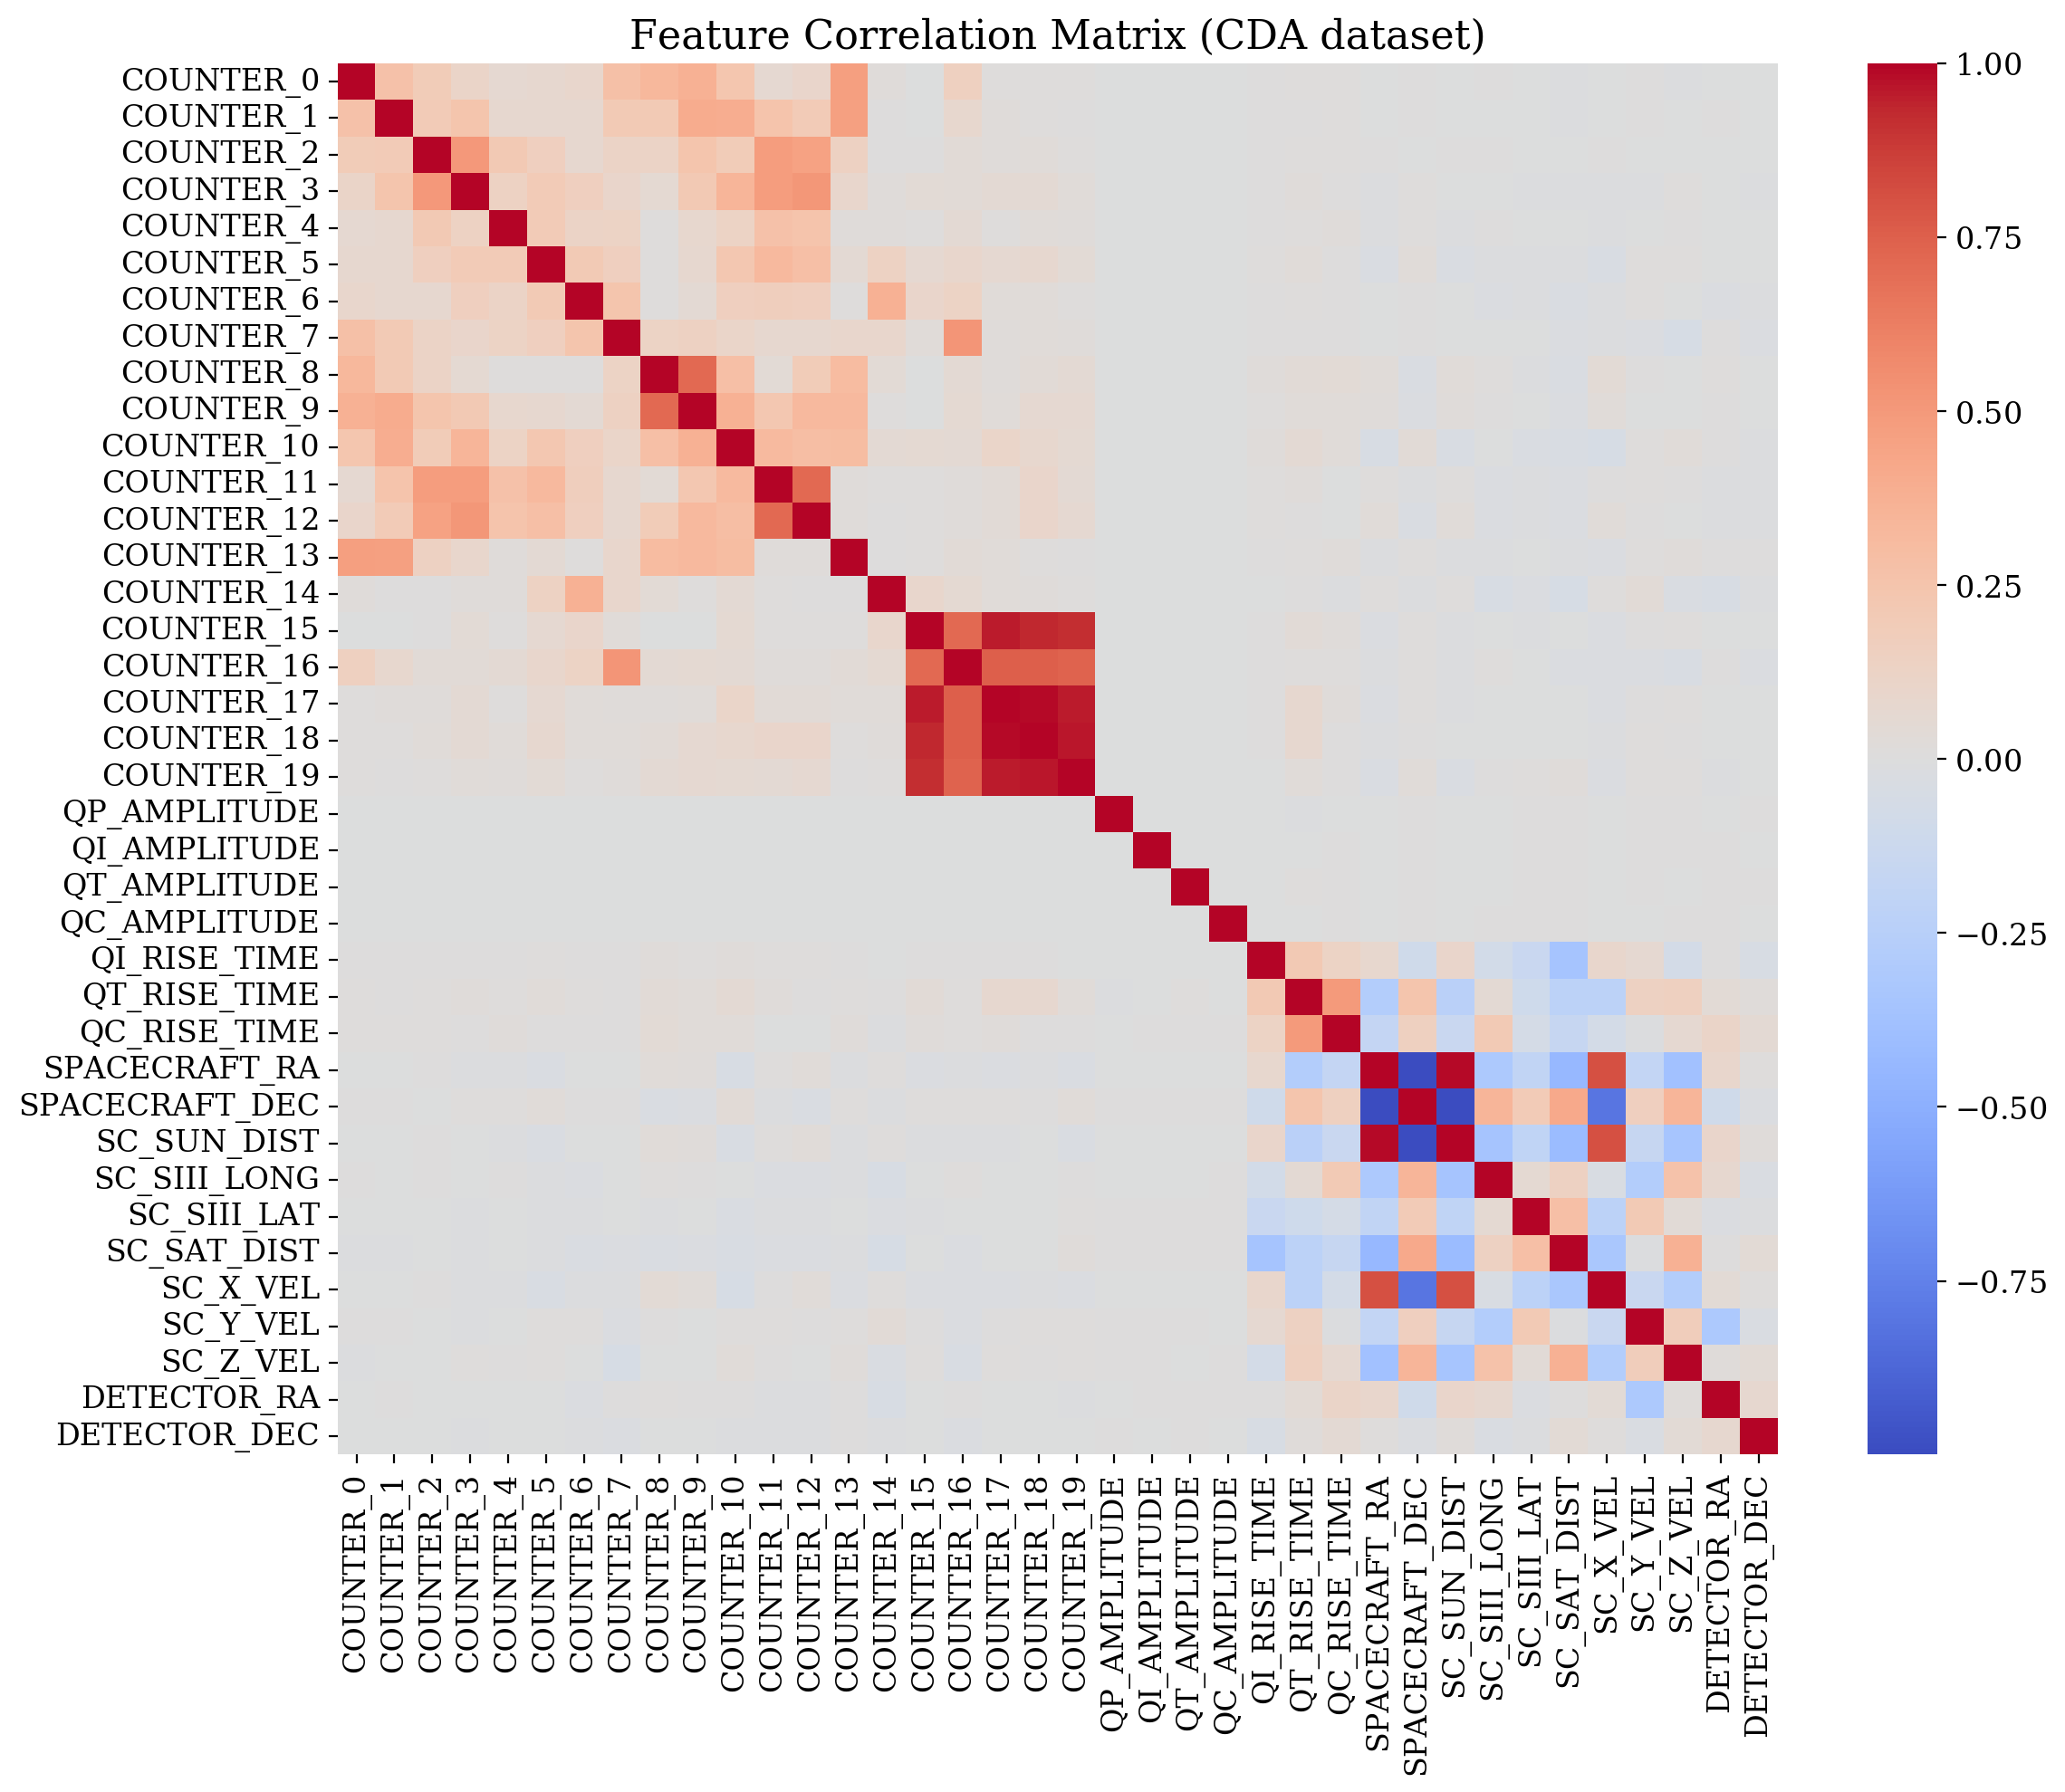

In [5]:
df_numeric = df.select_dtypes(include="number")

correlation_matrix = df_numeric.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Feature Correlation Matrix (CDA dataset)")
plt.grid(False)
plt.show()

In [6]:
dropped_columns=[]

def drop_correlated_columns(dataframe, dropped_columns, threshold=0.9):

    corr_matrix = dataframe.corr().abs()
    # Create an upper triangle matrix mask (ignore lower triangle)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    for col in upper.columns:
        # Find highly correlated features in this column
        high_corr = upper[col][upper[col] > threshold].index.tolist()
        for feature in high_corr:
            # Prioritize dropping the feature with more missing data or lower variance
            missing_col = dataframe[col].isna().sum()
            missing_feat = dataframe[feature].isna().sum()
            var_col = dataframe[col].var()
            var_feat = dataframe[feature].var()
            
            if missing_feat > missing_col:
                dropped_columns.append(feature)
            elif missing_feat < missing_col:
                dropped_columns.append(col)
            else:
                # If equal missing, drop one with lower variance
                if var_feat < var_col:
                    dropped_columns.append(feature)
                else:
                    dropped_columns.append(col)

    # Remove duplicates and keep only those present in DataFrame
    dropped_columns = list(set(dropped_columns))
    dropped_columns = [col for col in dropped_columns if col in dataframe.columns]

    # Drop columns
    new_dataframe = dataframe.drop(columns=dropped_columns)

    print(f"Dropped {len(dropped_columns)} highly correlated columns: {dropped_columns}")
    return new_dataframe

In [7]:
dropped_columns = []

df_temp = drop_correlated_columns(df_numeric, dropped_columns)
df_new = df.drop(columns=dropped_columns)
 

Dropped 5 highly correlated columns: ['COUNTER_18', 'SC_SUN_DIST', 'SPACECRAFT_DEC', 'COUNTER_17', 'COUNTER_15']


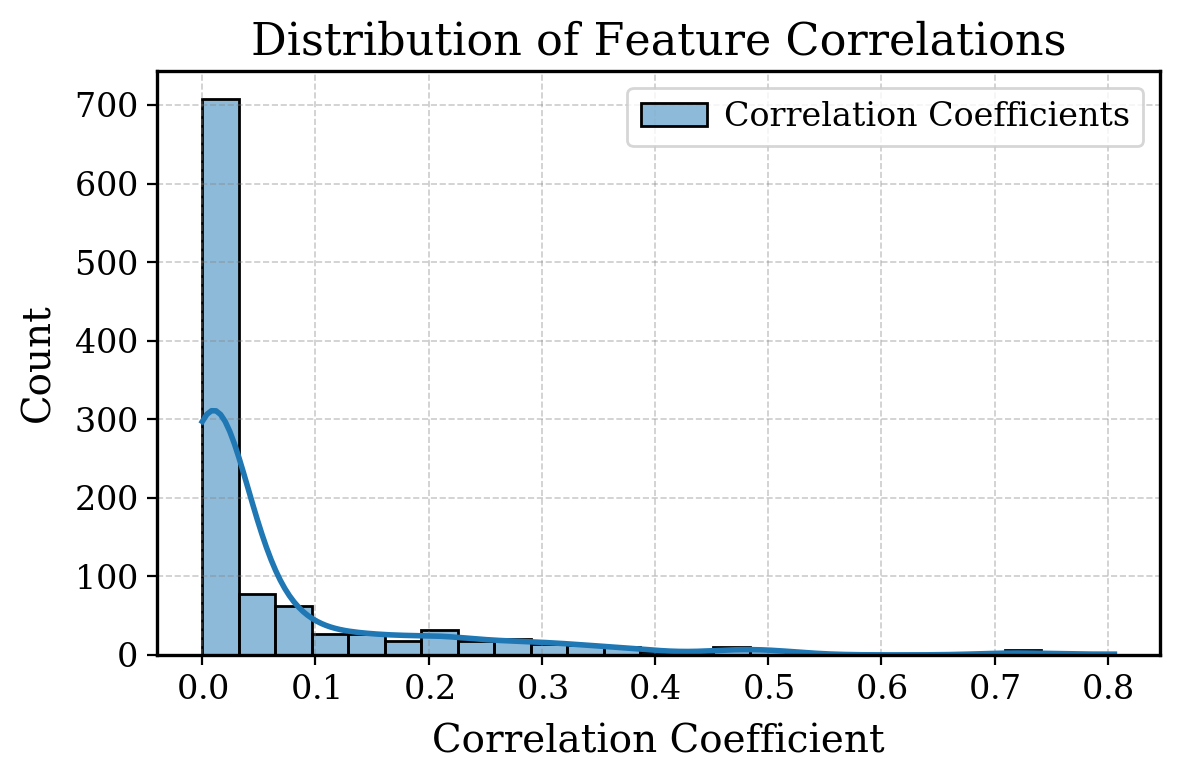

In [8]:
# Correlation distribution
correlation_values = np.abs(df_temp.corr().values.flatten())

# Remove self-correlations (1.0)
correlation_values = correlation_values[correlation_values != 1.0]

# Distribution function plot
plt.figure(figsize=(6, 4))
sns.histplot(correlation_values, bins=25, kde=True, label='Correlation Coefficients')
plt.legend()
plt.xlabel("Correlation Coefficient")
plt.ylabel("Count")
plt.title("Distribution of Feature Correlations")
plt.savefig("Figures/Correlation_Distribution_CDA.pdf")
plt.show()

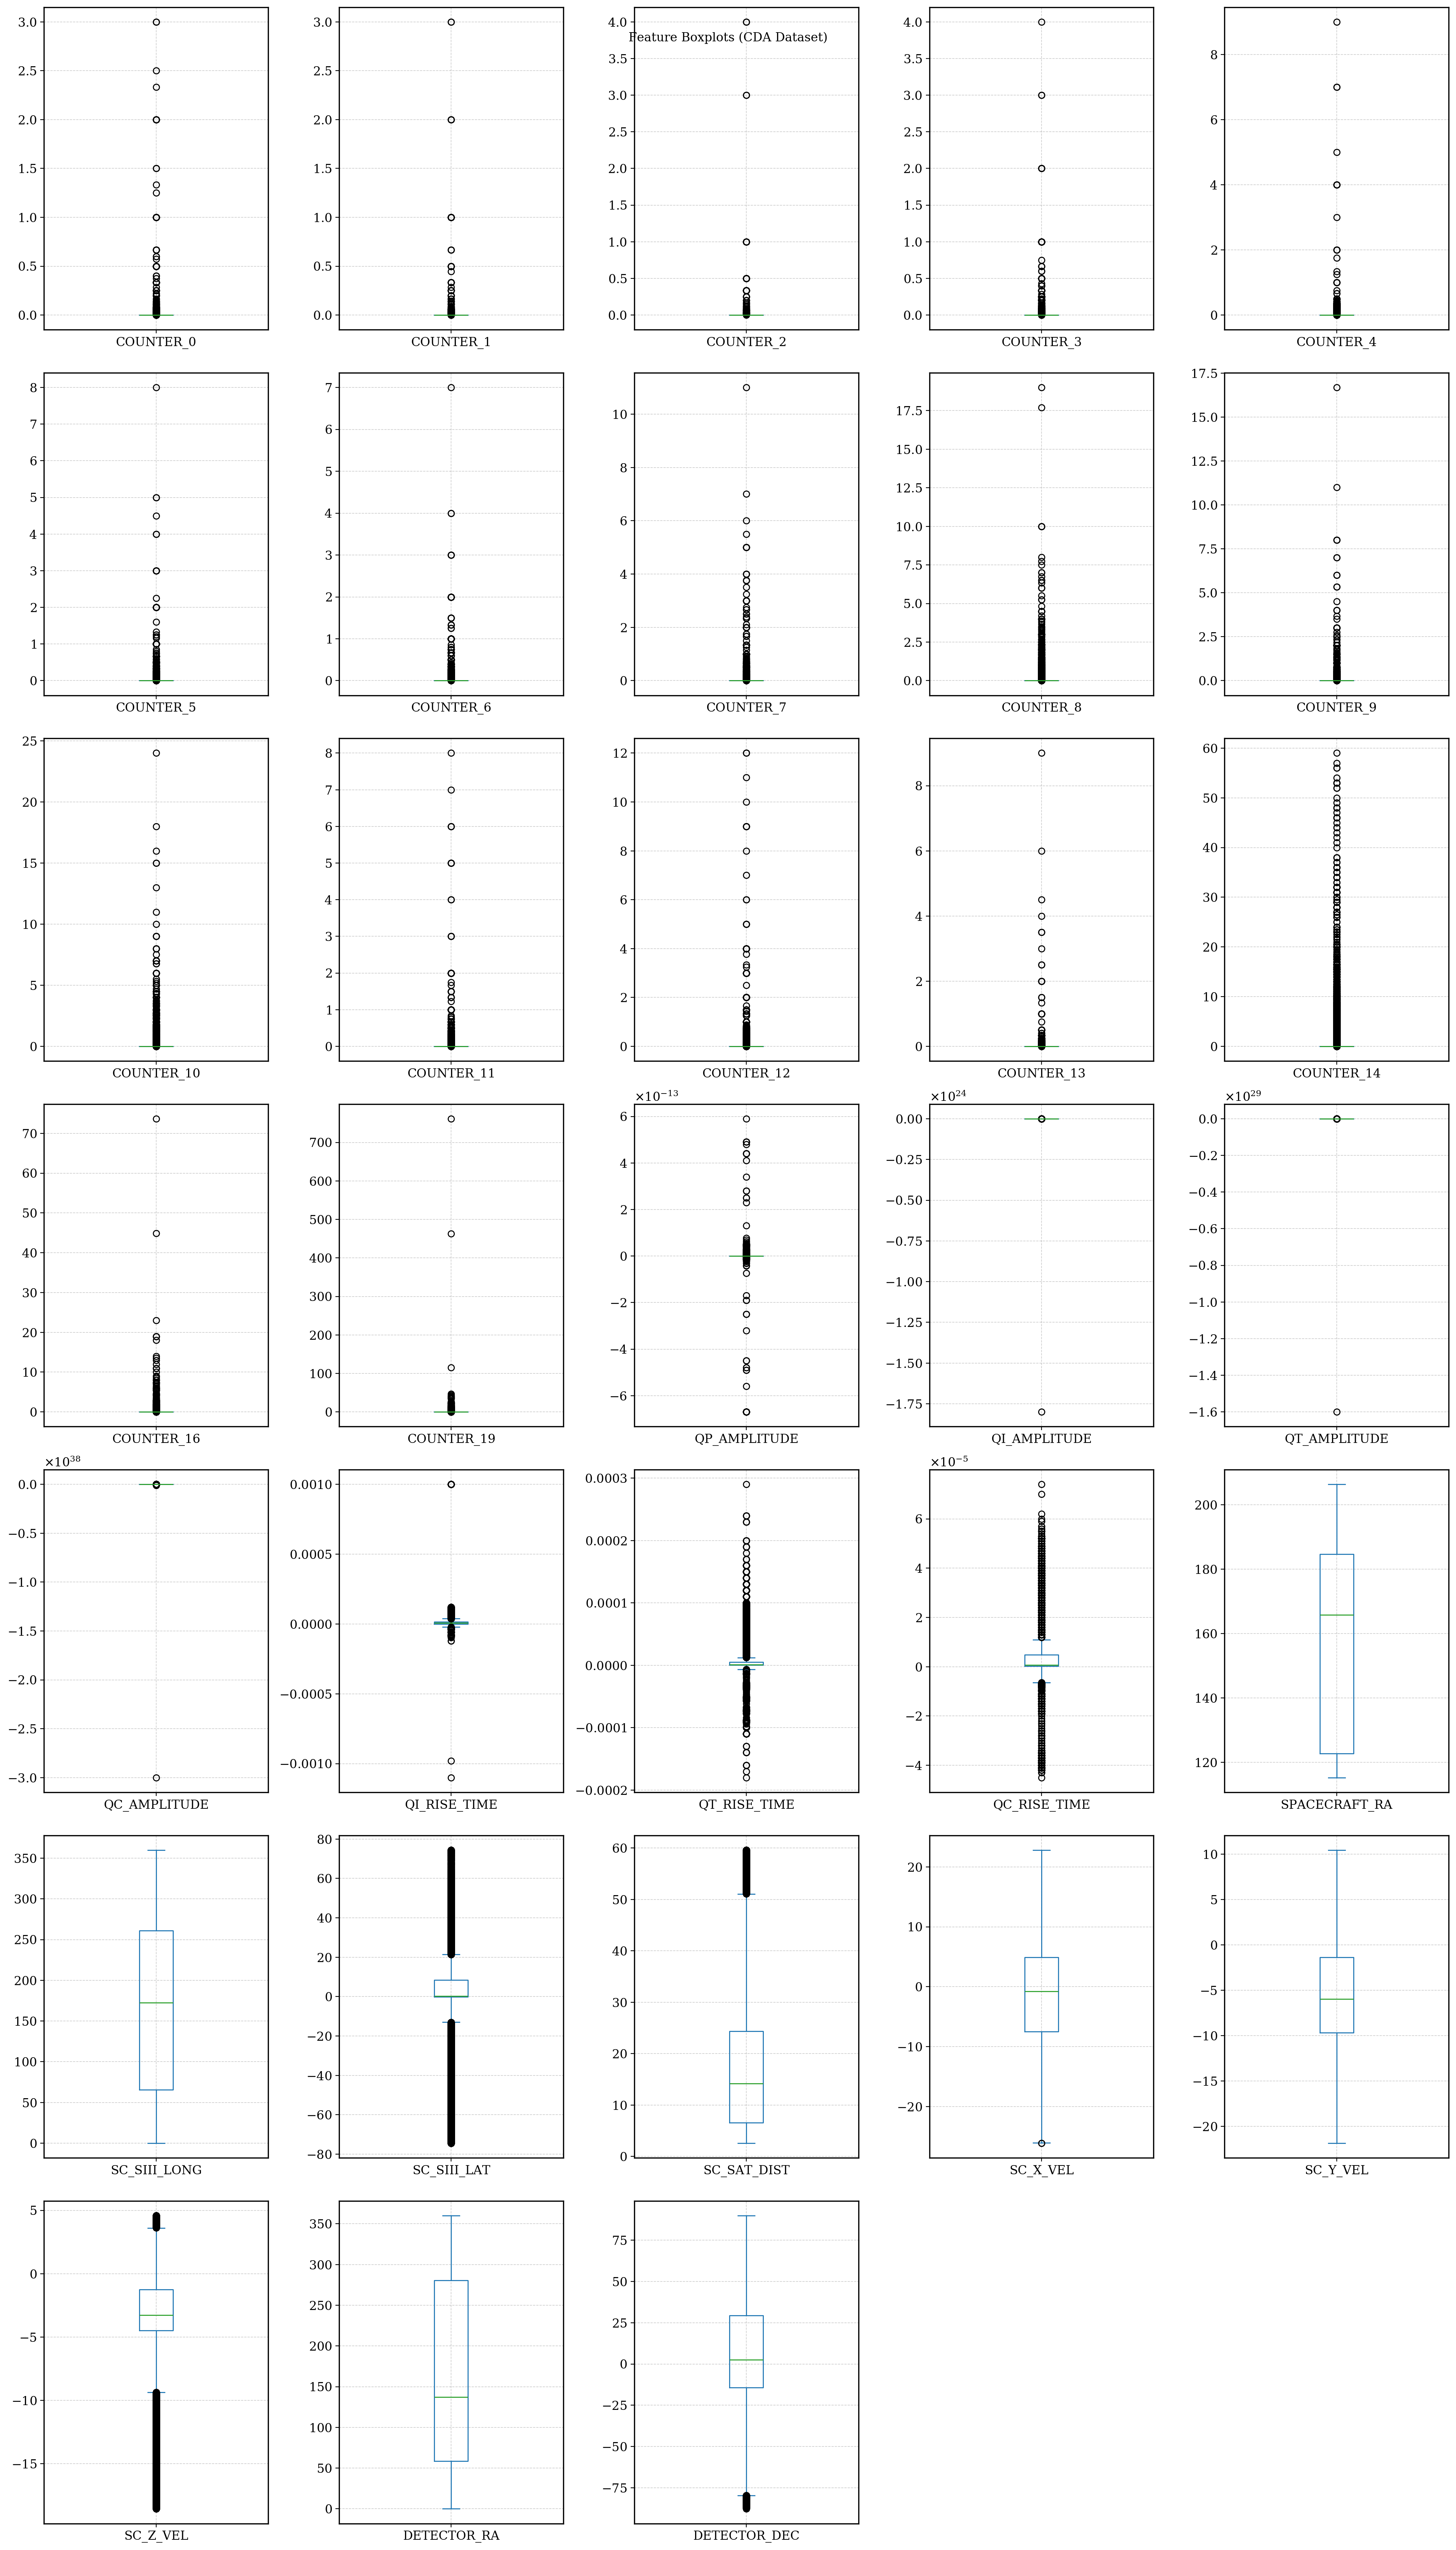

In [9]:
df_temp.plot(kind='box', subplots=True, layout=(8, 5), figsize=(20, 40), sharex=False, sharey=False)
plt.suptitle("Feature Boxplots (CDA Dataset)")
plt.tight_layout()
plt.show()

QI, QT, QC Amplitudes show some extreme outliers and distributions, rise times are moderately well behaved but with many outliers (noise?), SC parameters are generally well behaved with classic box shape and less dominant outliers.

Counts look reasonable with outliers for higher count events, we can already see events with large counts, while most of the background is rather low

Lets analyze the amplitude distributions

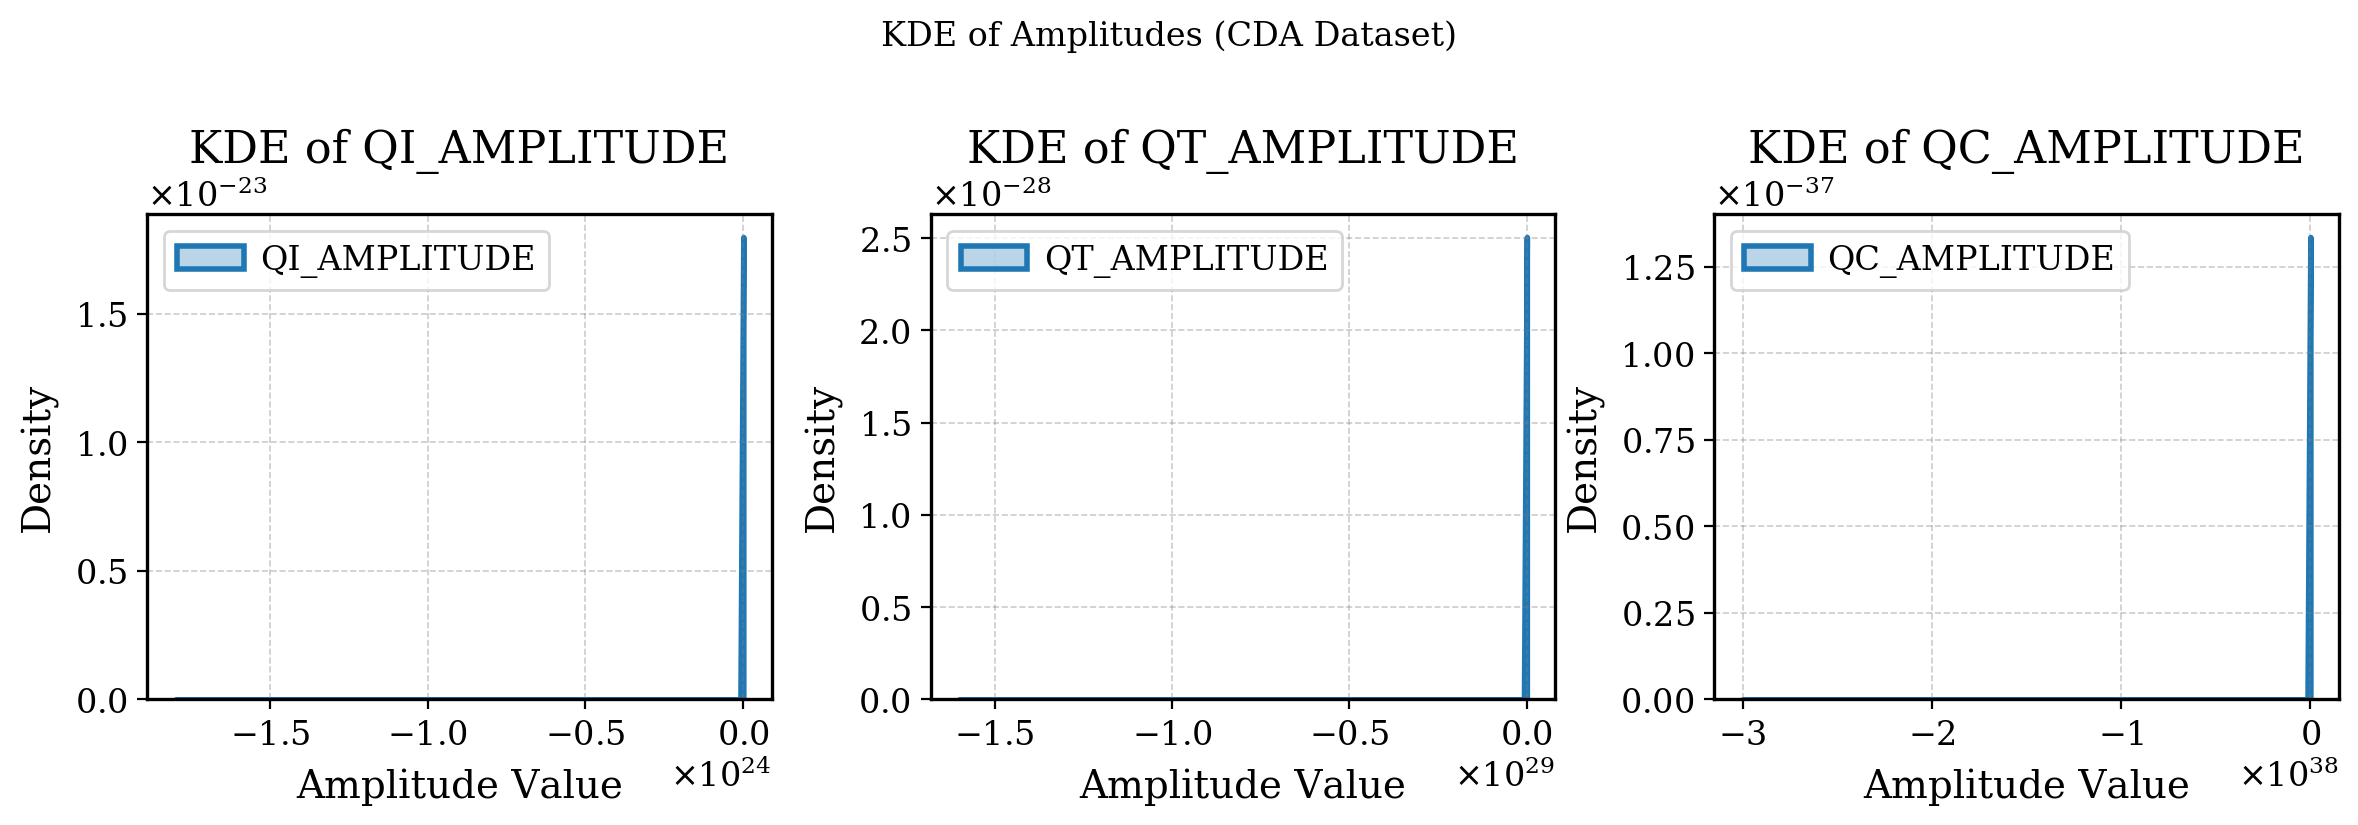

In [10]:
amplitude_cols = [
    "QI_AMPLITUDE",
    "QT_AMPLITUDE",
    "QC_AMPLITUDE"
]

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs = axs.flatten()

for i, col in enumerate(amplitude_cols):
    ax = axs[i]
    data = df_new[col].dropna()
    sns.kdeplot(data, label=col, fill=True, alpha=0.3, lw=2, ax=ax)
    ax.set_xlabel("Amplitude Value")
    ax.set_ylabel("Density")
    ax.set_title(f"KDE of {col}")
    ax.legend()

plt.suptitle("KDE of Amplitudes (CDA Dataset)", y=1.02)
plt.tight_layout()
plt.show()

Very extreme distributions as expected, lets use quantile clipping to remove unreasonable values.

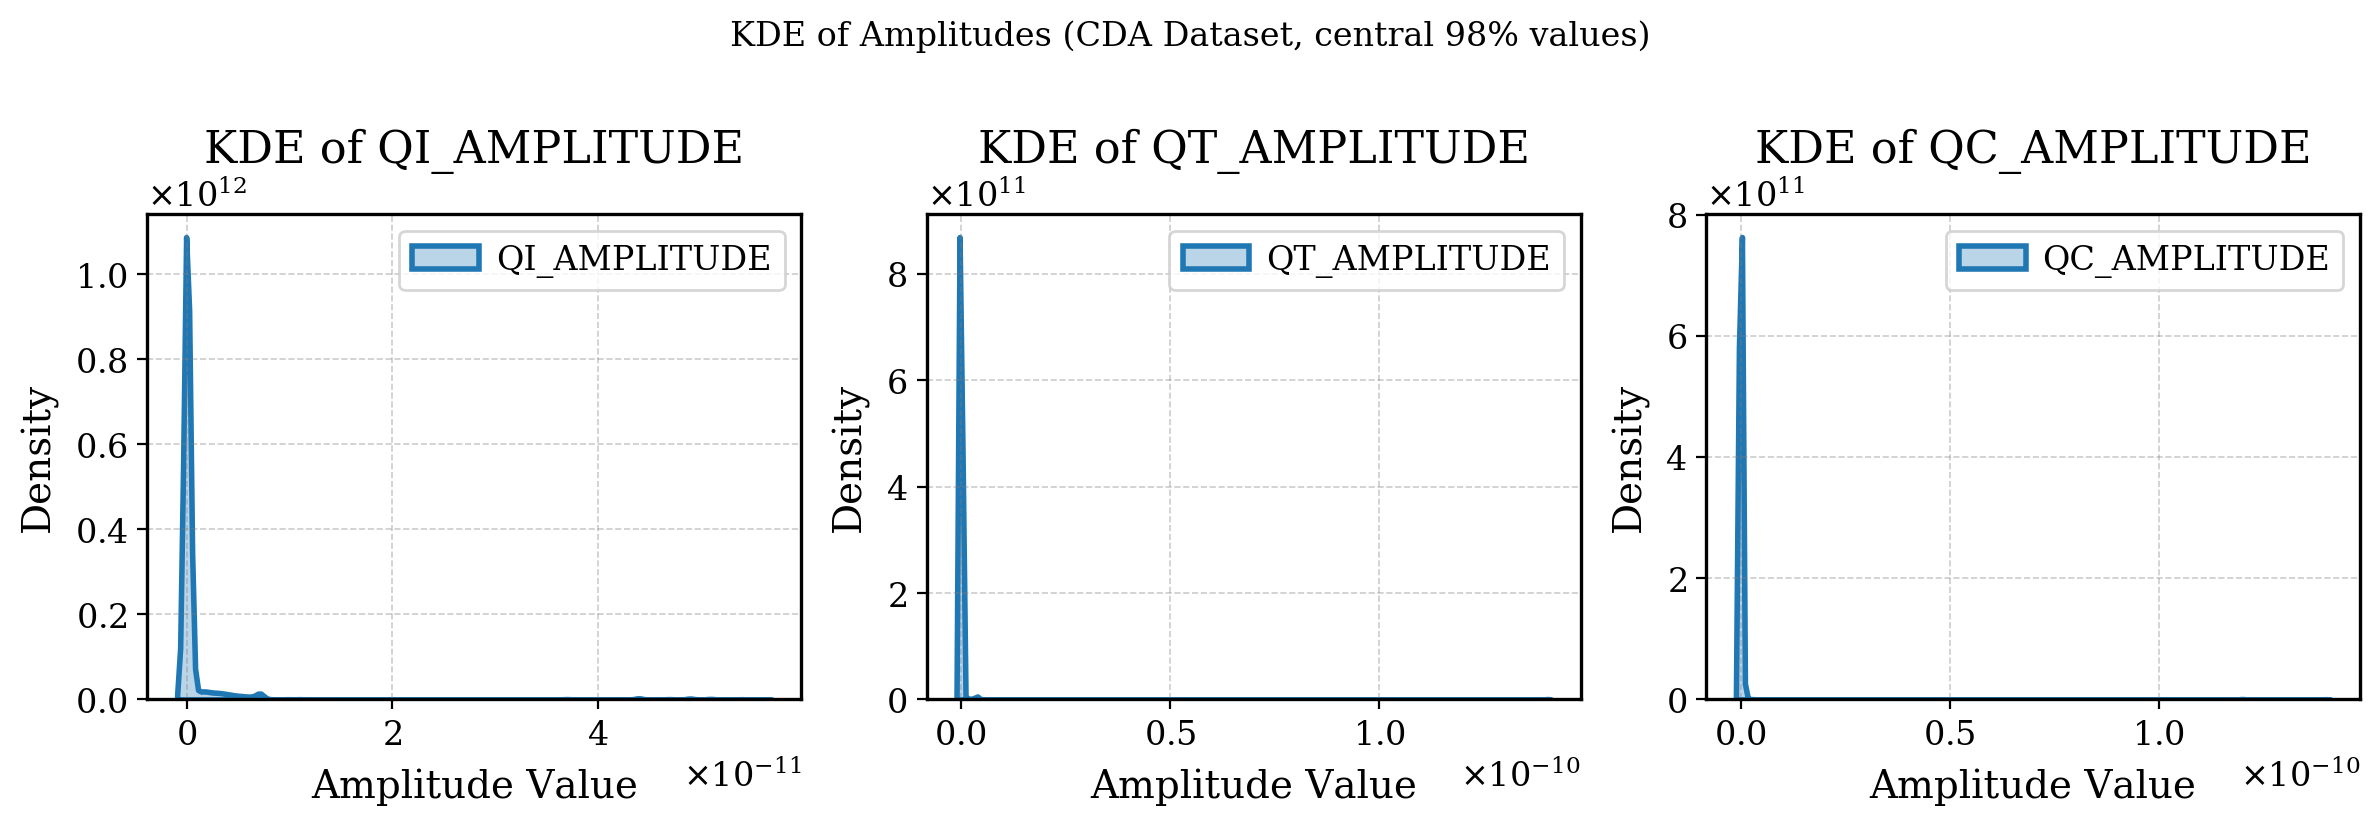

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs = axs.flatten()

for i, col in enumerate(amplitude_cols):
    ax = axs[i]
    col_data = df_new[col].dropna()
    # Compute 1% and 99% quantiles to trim extremes
    low, high = col_data.quantile([0.001, 0.999])
    # Filter data within quantile bounds
    trimmed_data = col_data[(col_data >= low) & (col_data <= high)]
    sns.kdeplot(trimmed_data, label=col, fill=True, alpha=0.3, lw=2, ax=ax)
    ax.set_xlabel("Amplitude Value")
    ax.set_ylabel("Density")
    ax.set_title(f"KDE of {col}")
    ax.legend()

plt.suptitle("KDE of Amplitudes (CDA Dataset, central 98% values)", y=1.02)
plt.tight_layout()
plt.show()

A lot of improvement has been made for the amplitudes, we can see some right skewed distributions, but this is as expected as we have events where larger amplitudes are featured. Also compare magnitude scale to above!

In [12]:
# Limit the amplitude data to reasonable quantiles
amplitude_cols = ["QI_AMPLITUDE", "QT_AMPLITUDE", "QC_AMPLITUDE"]

for col in amplitude_cols:
    q_low = df_new[col].quantile(0.001)
    q_high = df_new[col].quantile(0.999)
    # Set values outside [q_low, q_high] to NaN
    df_new.loc[(df_new[col] < q_low) | (df_new[col] > q_high), col] = np.nan

In [13]:
df_new.head()

TIME  COUNTER_0  COUNTER_1  COUNTER_2  COUNTER_3  COUNTER_4  \
0 2005-01-01 00:00:34        0.0        0.0        0.0        0.0        0.0   
1 2005-01-01 00:01:38        0.0        0.0        0.0        0.0        0.0   
2 2005-01-01 00:02:42        0.0        0.0        0.0        0.0        0.0   
3 2005-01-01 00:03:46        0.0        0.0        0.0        0.0        0.0   
4 2005-01-01 00:04:50        0.0        0.0        0.0        0.0        0.0   

   COUNTER_5  COUNTER_6  COUNTER_7  COUNTER_8  ...  QC_RISE_TIME  \
0   0.000000        0.0        0.0        0.0  ...           NaN   
1   0.046875        0.0        0.0        0.0  ...           NaN   
2   0.031250        0.0        0.0        0.0  ...           NaN   
3   0.015625        0.0        0.0        0.0  ...           NaN   
4   0.015625        0.0        0.0        0.0  ...           NaN   

   SPACECRAFT_RA  SC_SIII_LONG  SC_SIII_LAT  SC_SAT_DIST  SC_X_VEL  SC_Y_VEL  \
0         115.32        223.44        12.46        59.63     -8.38     -4.45   
1         115.32        223.44        12.46        59.63     -8.38     -4.45   
2         115.32        223.44        12.46        59.63     -8.38     -4.45   
3         115.32        223.44        12.46        59.63     -8.38     -4.45   
4         115.32        223.44        12.46        59.63     -8.38     -4.45   

   SC_Z_VEL DETECTOR_RA DETECTOR_DEC  
0     -1.08       67.33        59.25  
1     -1.08       67.33        59.25  
2     -1.08       67.33        59.25  
3     -1.08       67.33        59.25  
4     -1.08       67.60        59.23  

[5 rows x 36 columns]

In [14]:
df_new.to_csv("CompiledDataSet/Cassini_CDA_Count+Event_V2.csv", index=True)

In [15]:
status_report = []
for vol in sorted(df_new['SOURCE_VOLUME'].unique()):
    group = df_new[df_new['SOURCE_VOLUME'] == vol]
    n_valid_times = group['TIME'].dropna().shape[0]
    first_time = group['TIME'].min()
    last_time = group['TIME'].max()
    status_report.append((vol, n_valid_times, first_time, last_time))
    
report_df = pd.DataFrame(status_report, columns=['Volume', 'TIME Counts', 'First TIME', 'Last TIME'])
print(report_df)


        Volume  TIME Counts          First TIME           Last TIME
0   COCDA_0007        84496 2005-01-01 00:00:34 2005-03-31 23:59:53
1   COCDA_0012        13827 2005-07-01 00:00:44 2005-07-21 23:58:48
2   COCDA_0045        27744 2008-03-02 00:00:39 2008-03-31 23:57:25
3   COCDA_0050        52664 2008-08-04 04:23:00 2008-08-30 18:15:21
4   COCDA_0052         5692 2008-10-01 00:00:38 2008-11-01 00:01:49
5   COCDA_0057        57727 2009-10-01 00:00:04 2009-12-31 23:54:25
6   COCDA_0059        39360 2010-04-01 00:00:54 2010-06-30 23:35:06
7   COCDA_0061        20399 2010-10-01 00:00:05 2010-12-31 22:29:50
8   COCDA_0069        21251 2011-10-01 00:00:09 2011-10-31 22:46:35
9   COCDA_0070         7861 2011-11-01 00:00:56 2011-12-01 23:10:10
10  COCDA_0074        20983 2012-03-03 00:00:53 2012-03-29 06:59:50
11  COCDA_0075          803 2012-03-31 21:00:52 2012-04-14 19:26:34
12  COCDA_0076        13987 2012-05-02 06:17:05 2012-06-01 23:57:11
13  COCDA_0094        84119 2015-10-03 00:02:49 

In [16]:
flybys = [
    ("E3",  "2008-03-12 19:06:45"), #Confirmed YDong
    ("E4",  "2008-08-11 21:06:30"), # Confirmed
    ("E5",  "2008-10-09 19:07:00"), # Confirmed
    ("E6",  "2008-10-31 17:15:30"), #Confirmed
    ("E7",  "2009-11-02 07:42:00"), #Confirmed
    ("E9",  "2010-04-28 00:10:00"), #Half confirmed
    ("E10", "2010-05-18 06:01:17"),
    ("E12", "2010-11-30 11:54:00"), # Half confirmed
    ("E13", "2010-12-21 01:08:00"), #Half confirmed
    ("E14", "2011-10-01 13:52:26"), # Confirmed
    ("E17", "2012-03-27 18:30:09"), # Confirmed
    ("E18", "2012-04-14 14:01:30"), #Confirmed
    ("E19", "2012-05-02 09:31:00"), # Half confirmed
    ("E21", "2015-10-28 15:22:42"), #Half confirmed
]

flyby_times = [(name, pd.to_datetime(timestr)) for name, timestr in flybys]

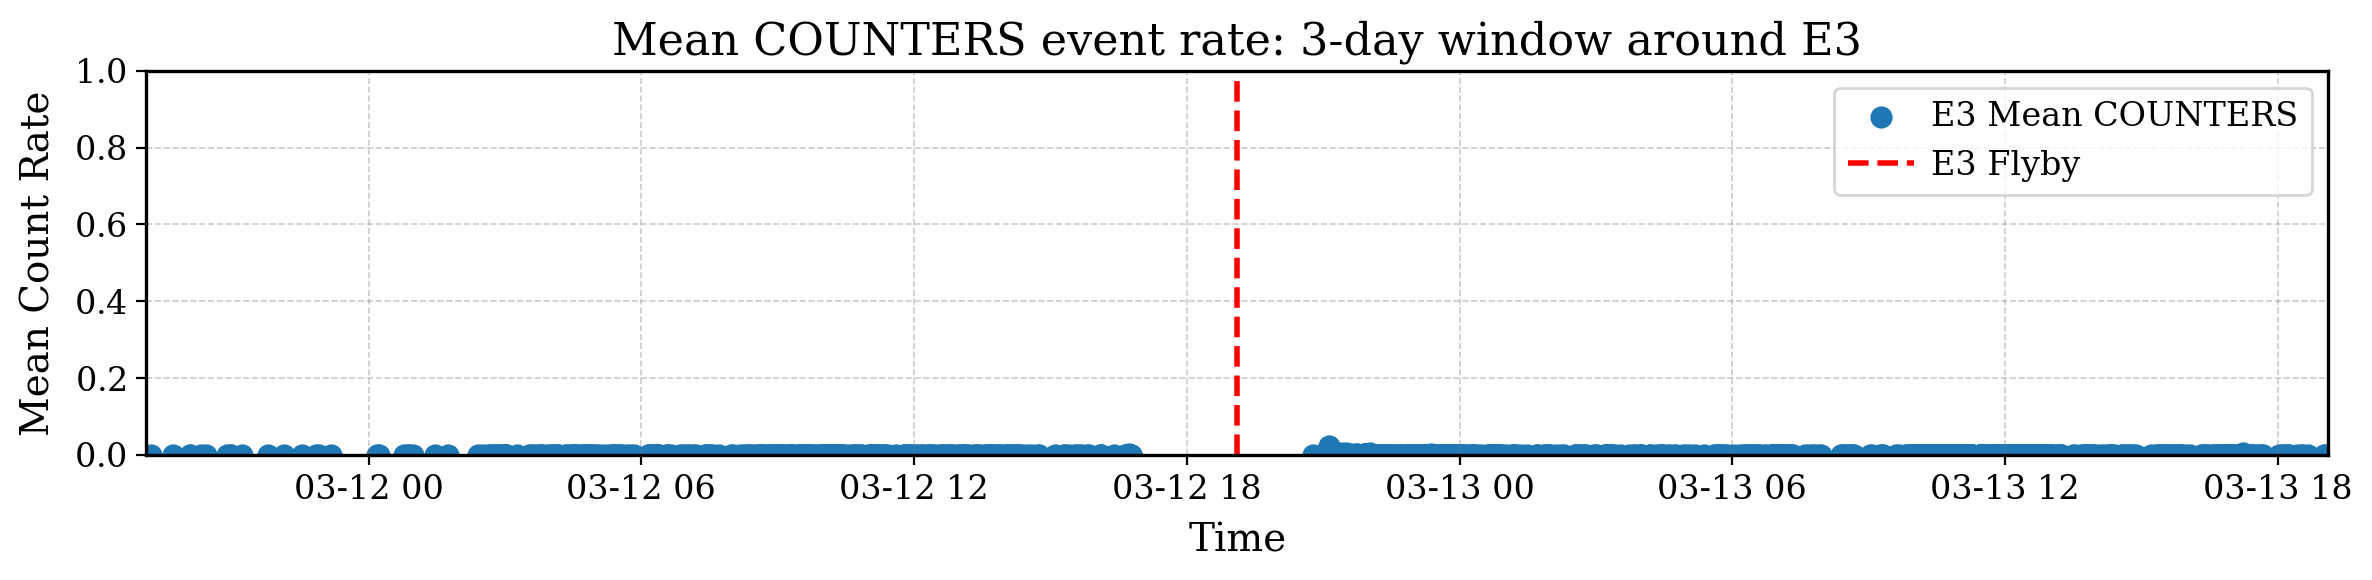

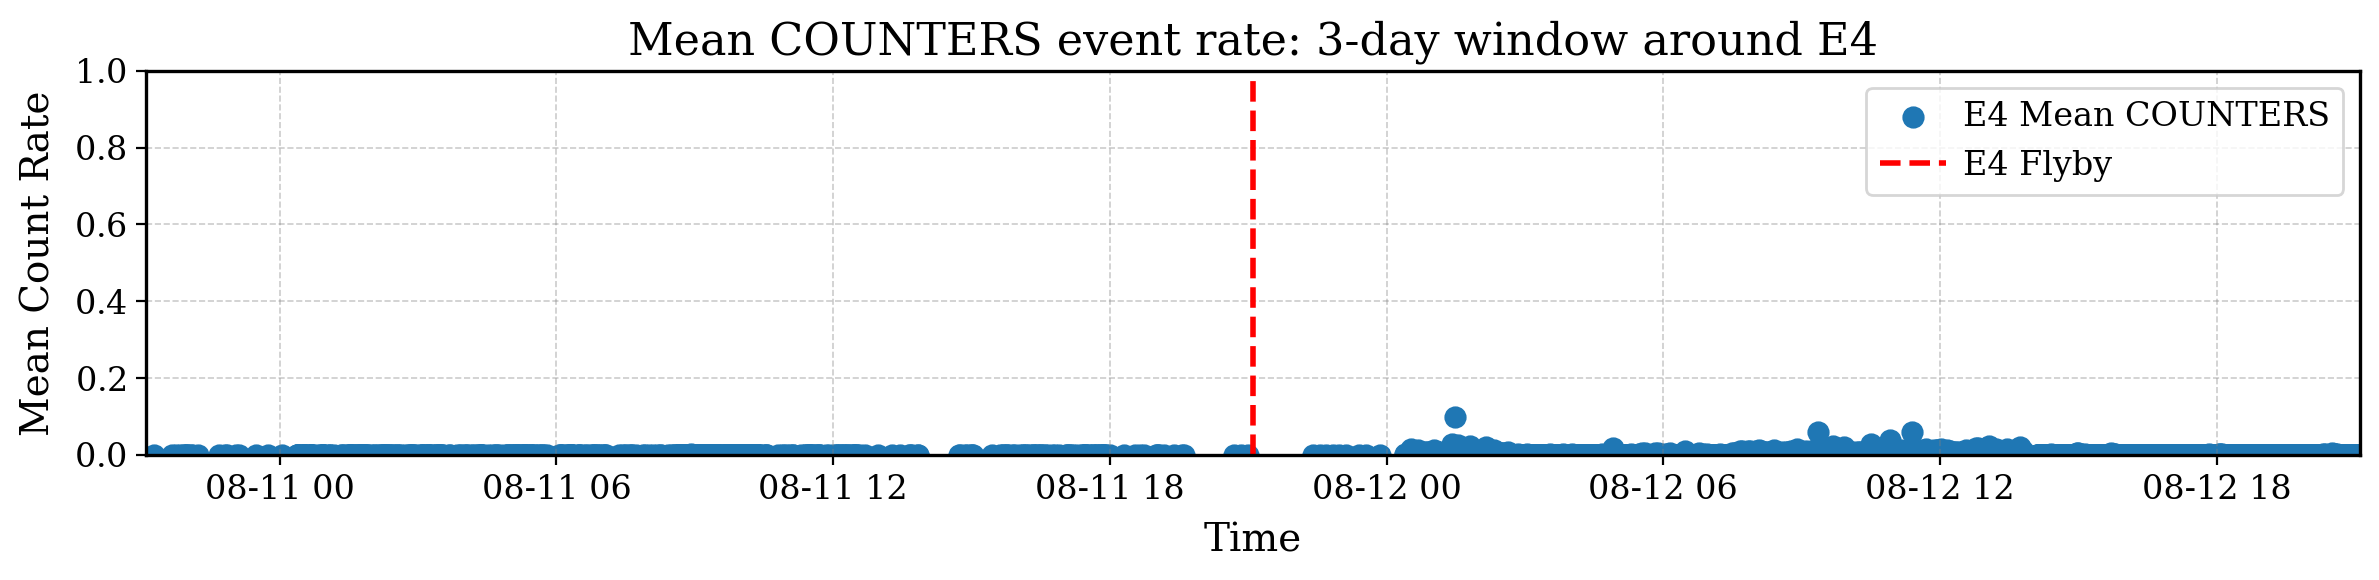

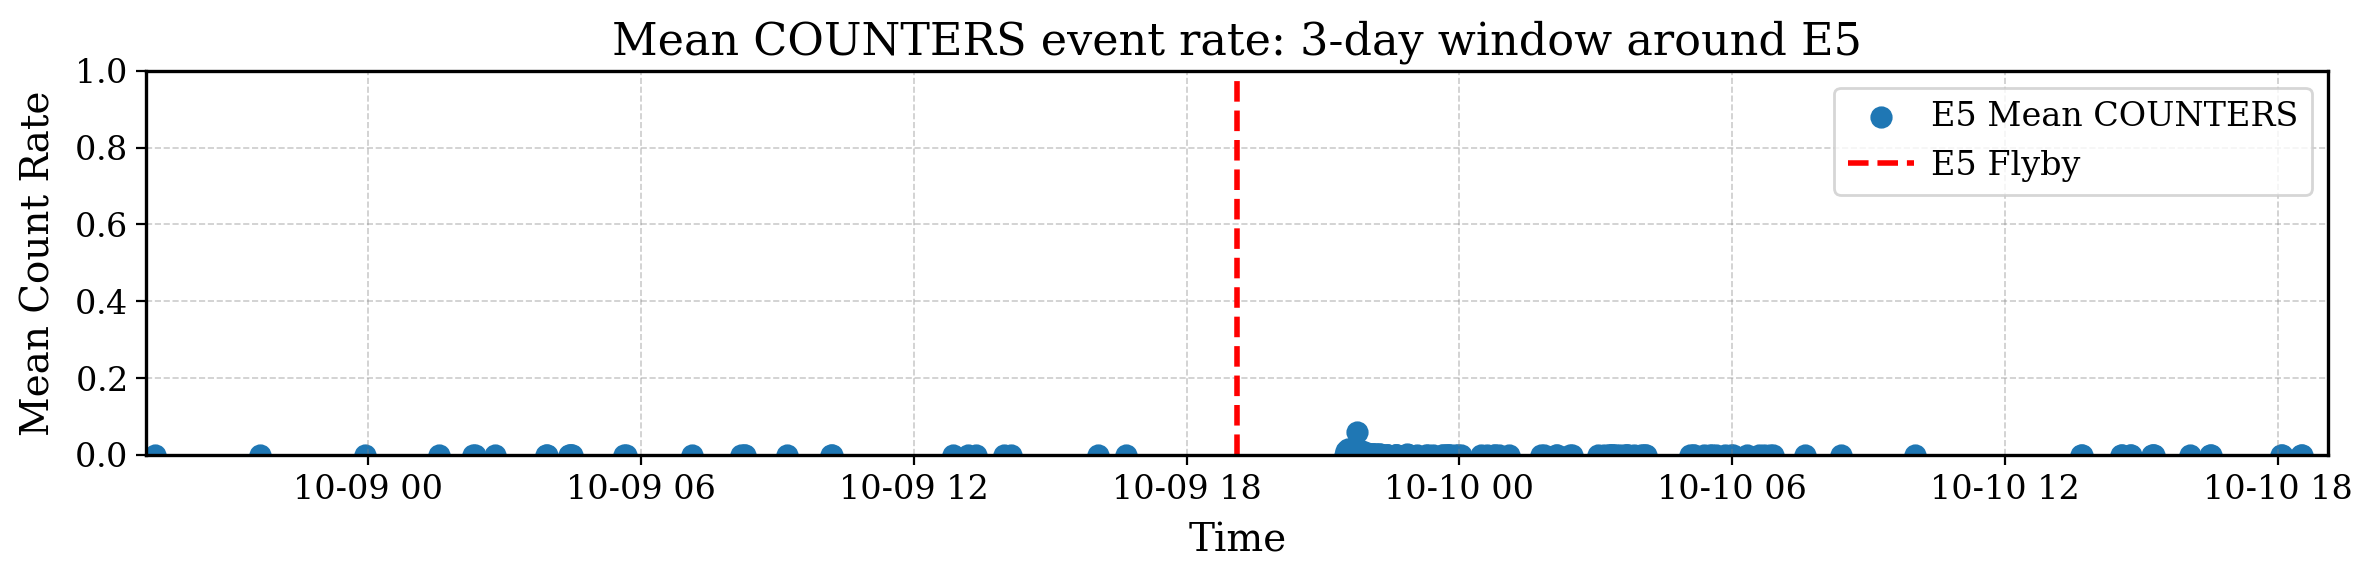

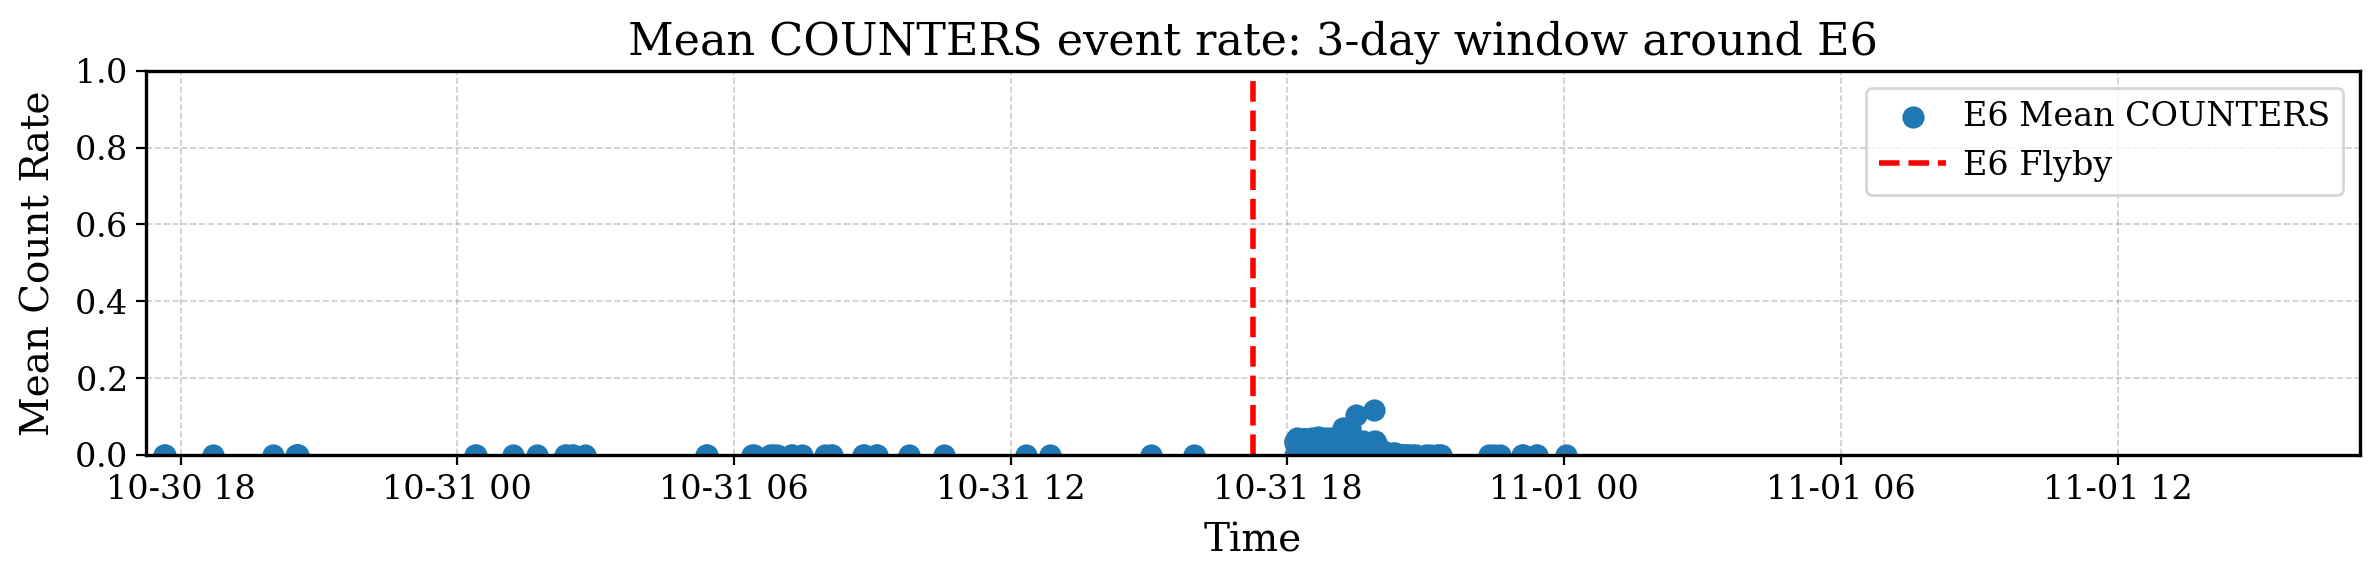

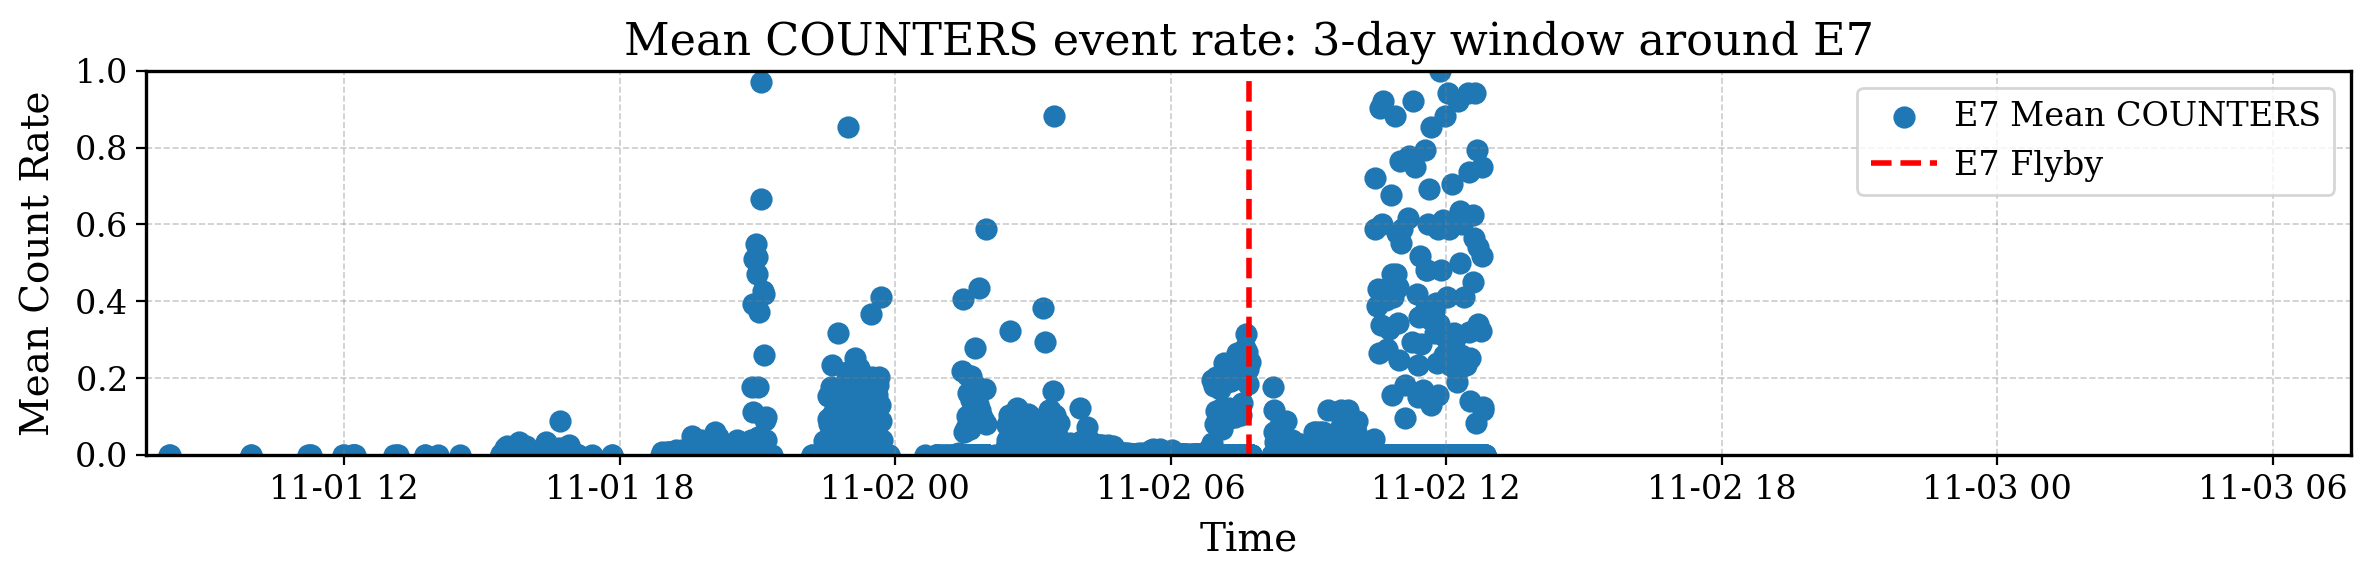

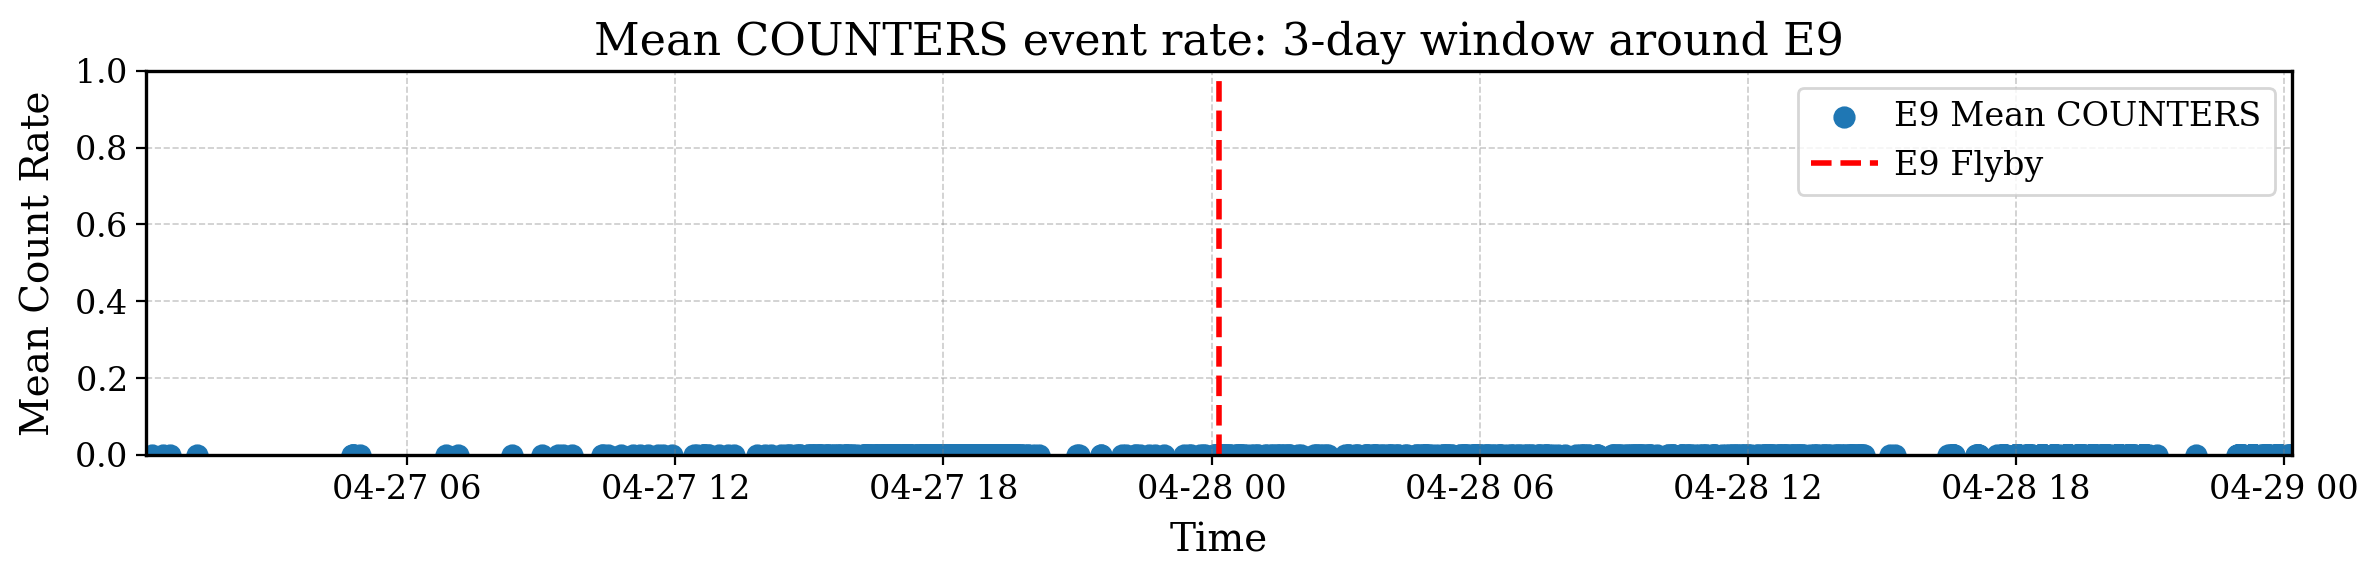

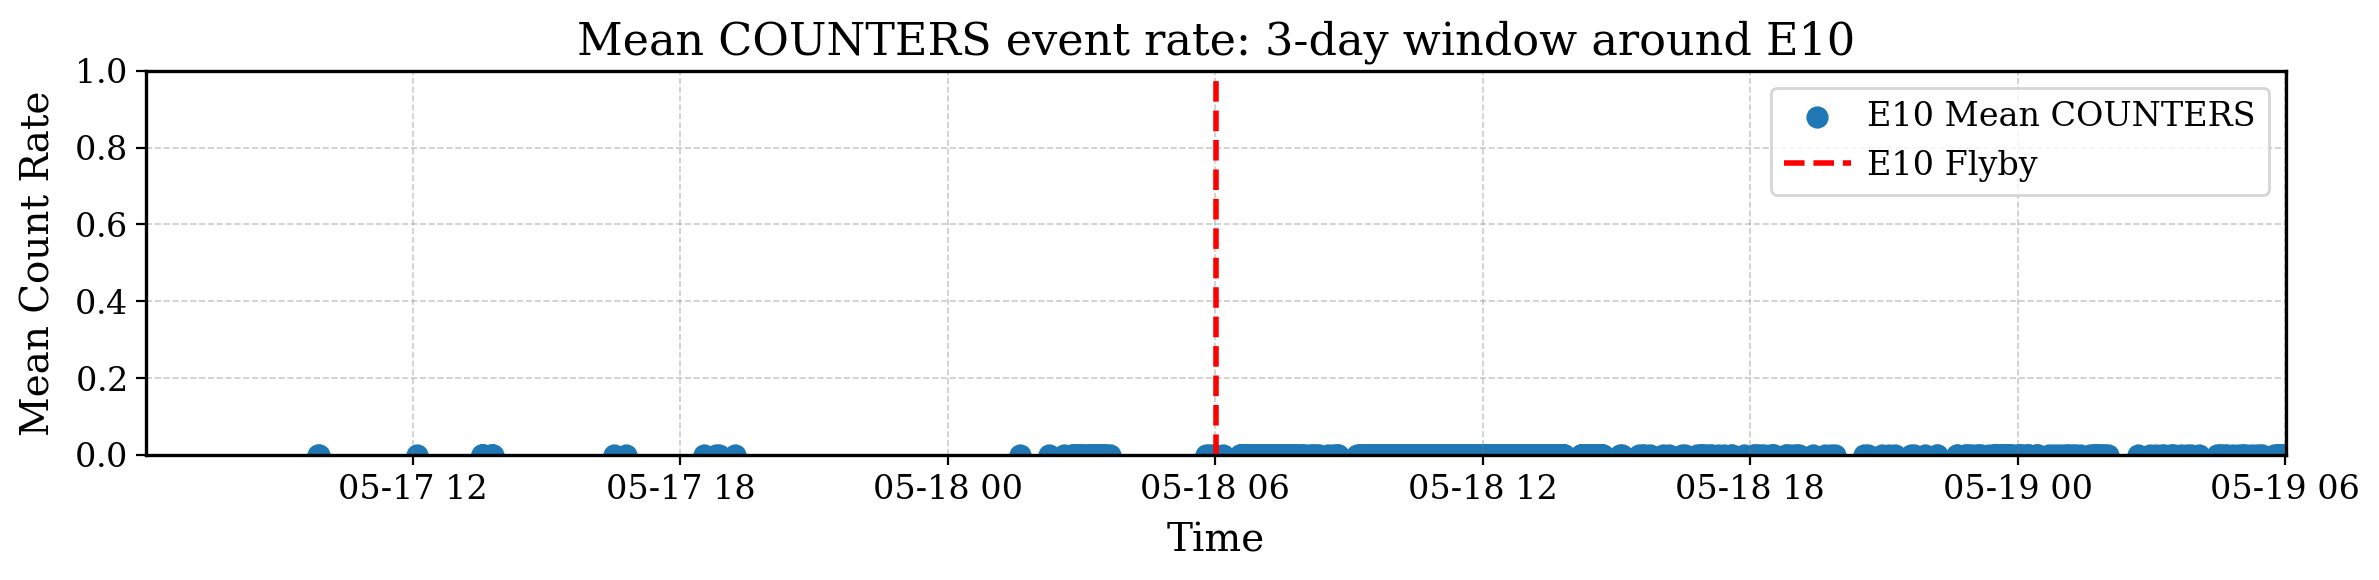

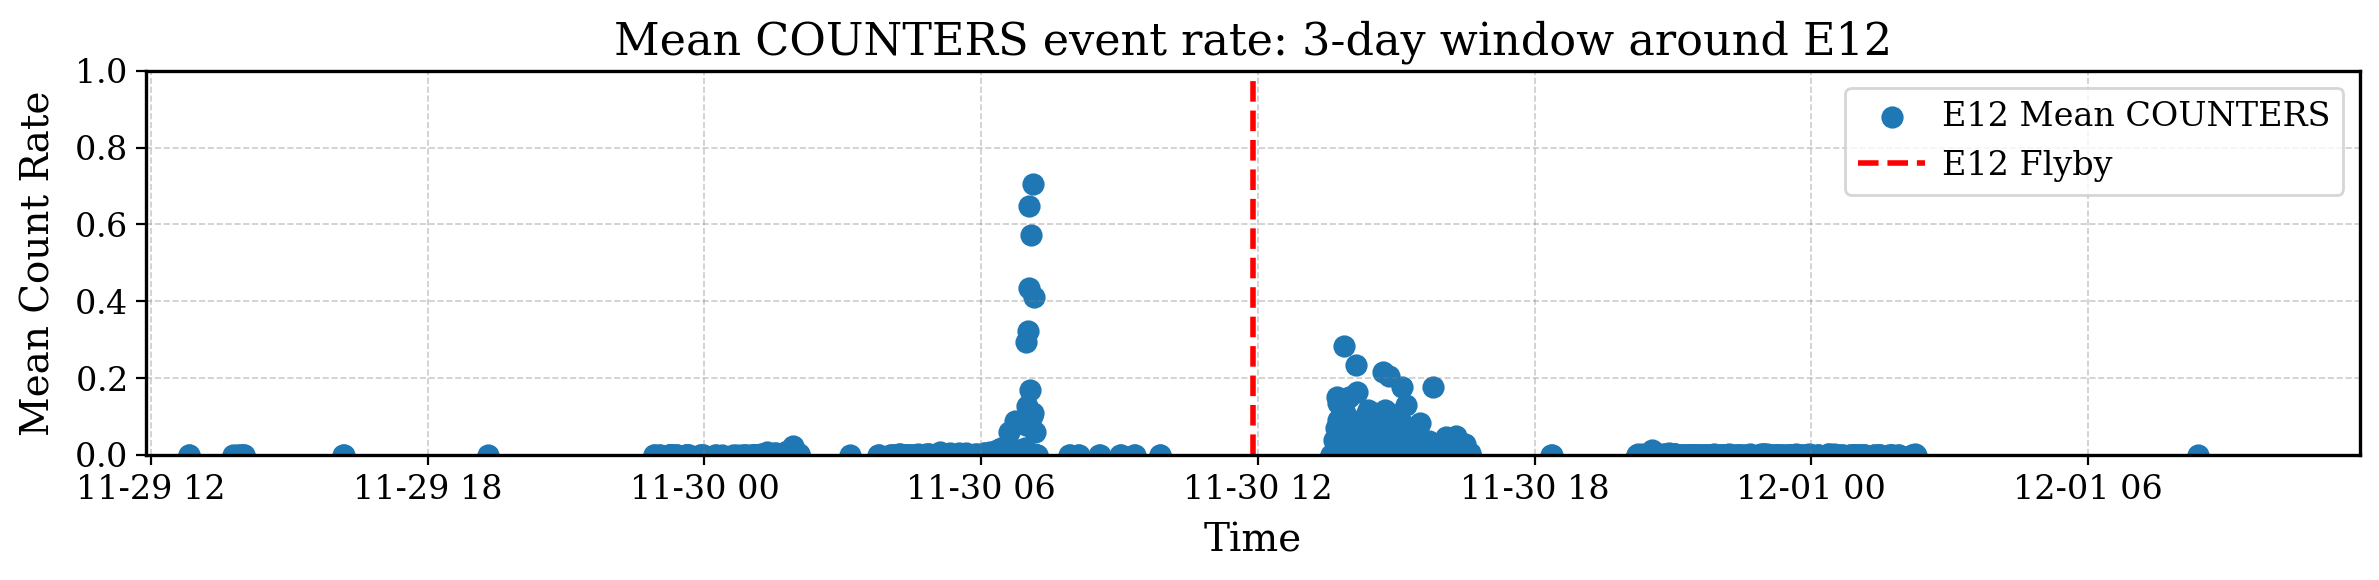

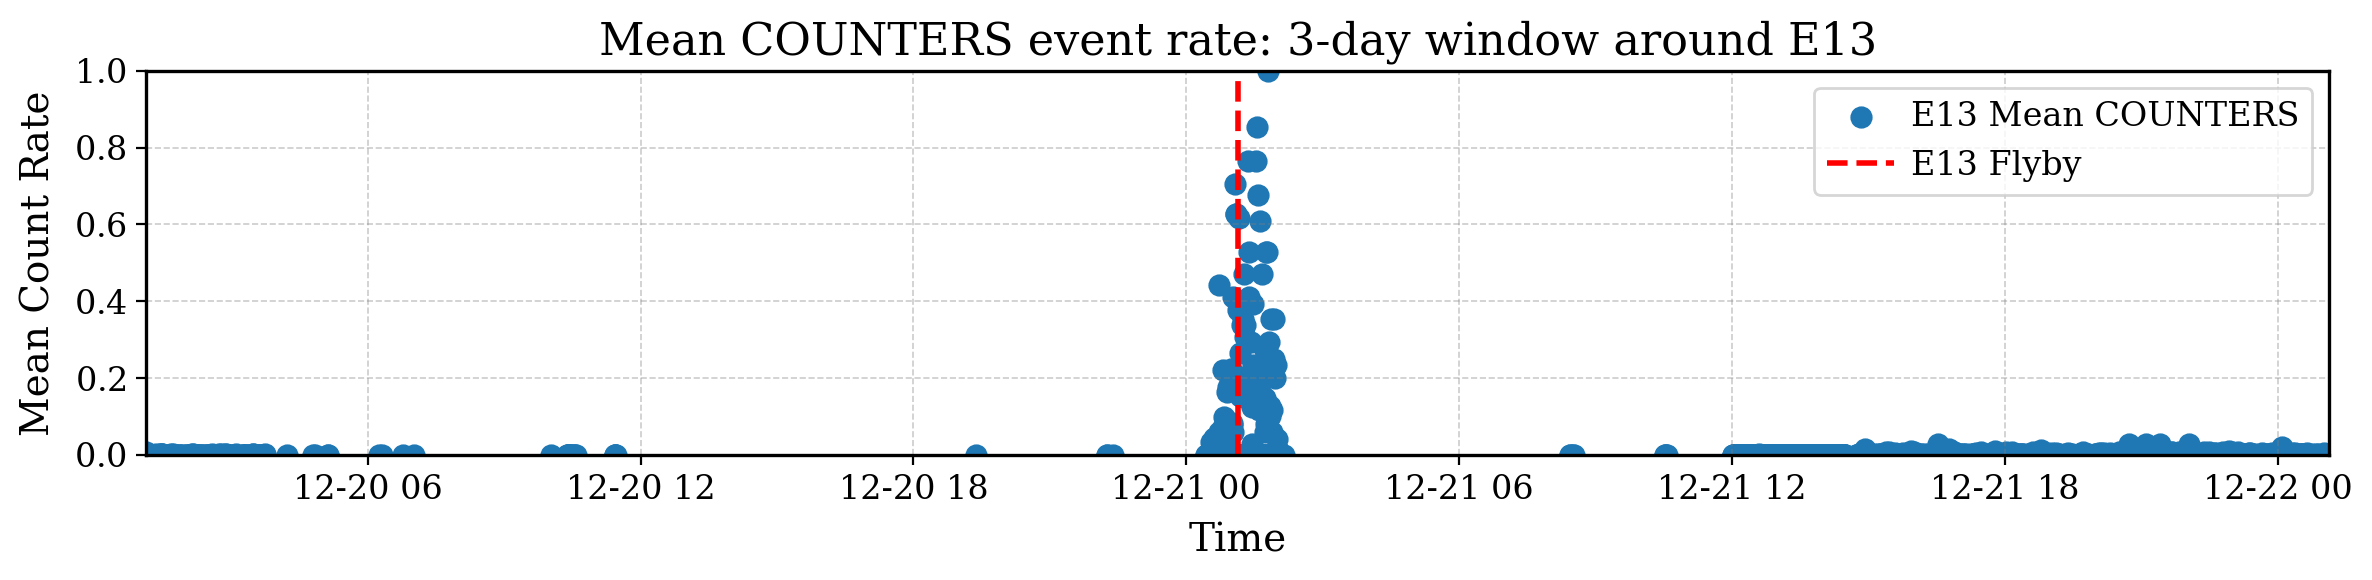

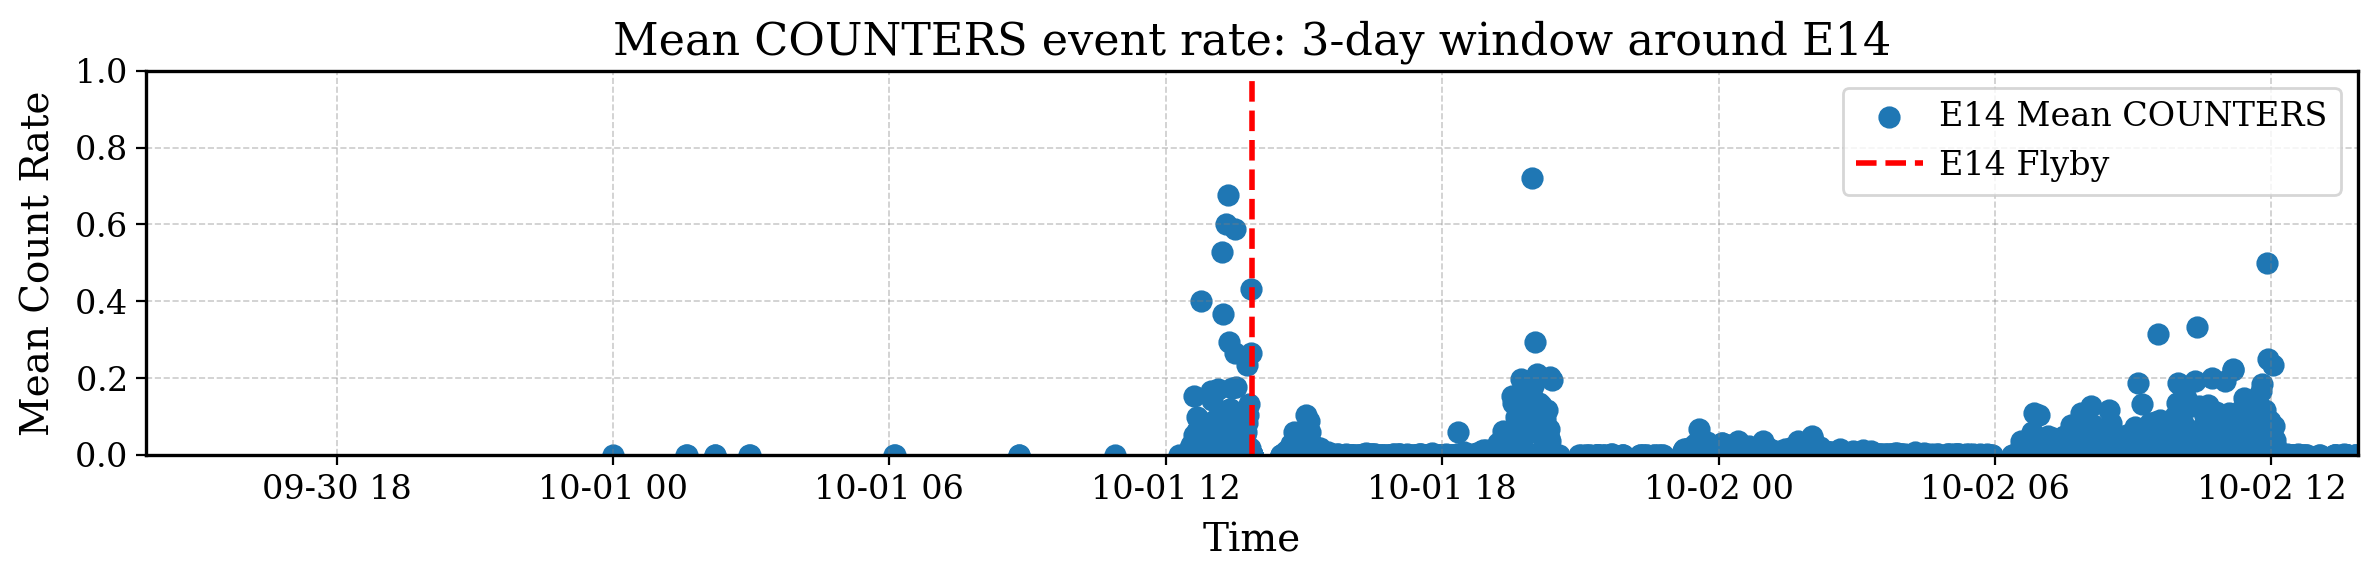

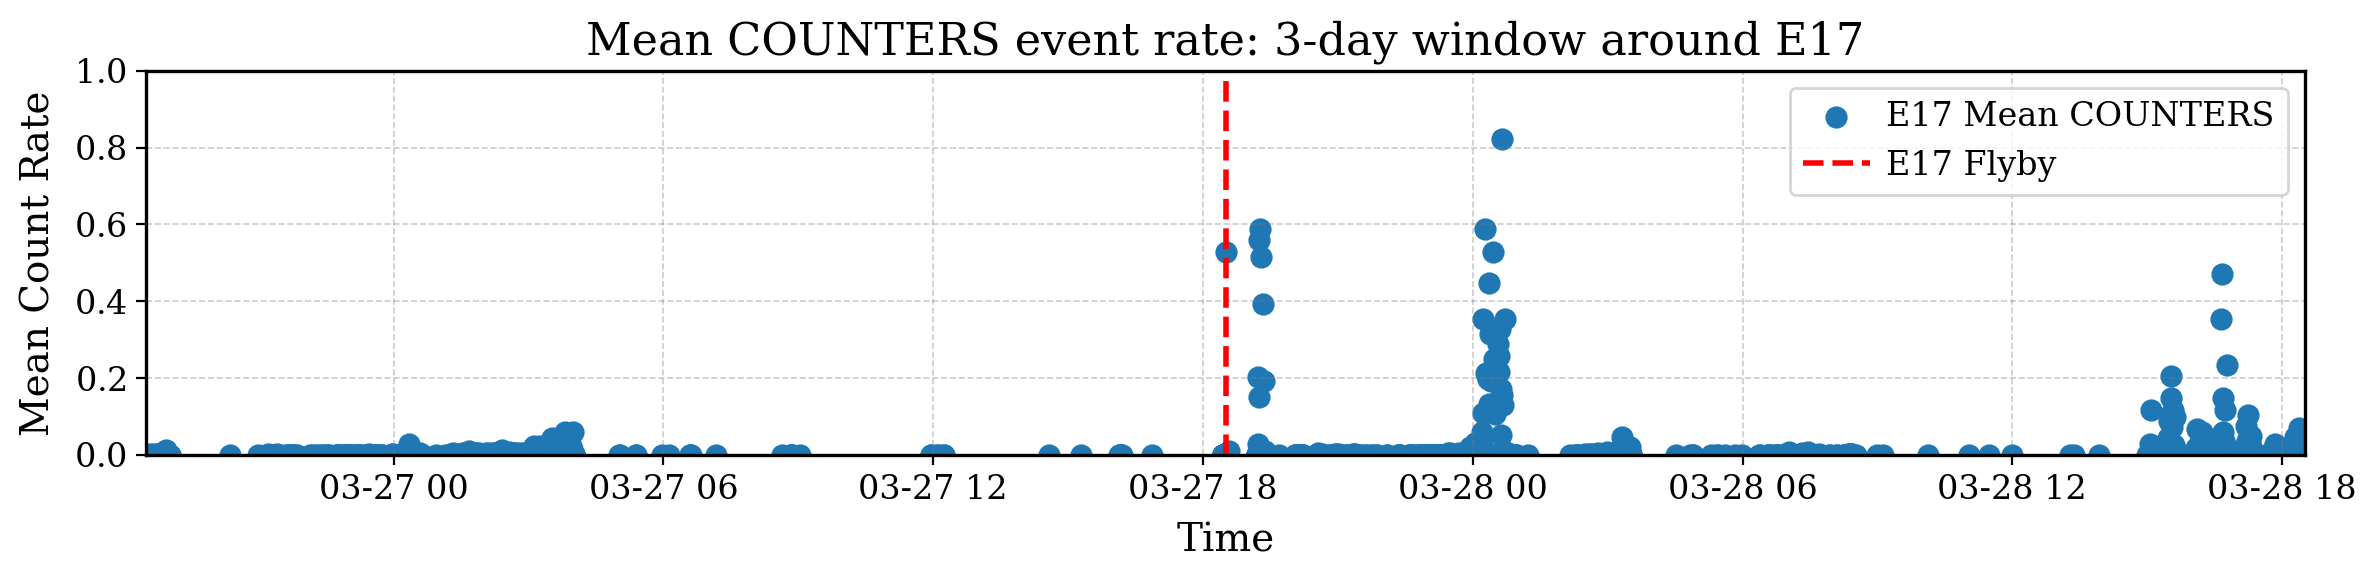

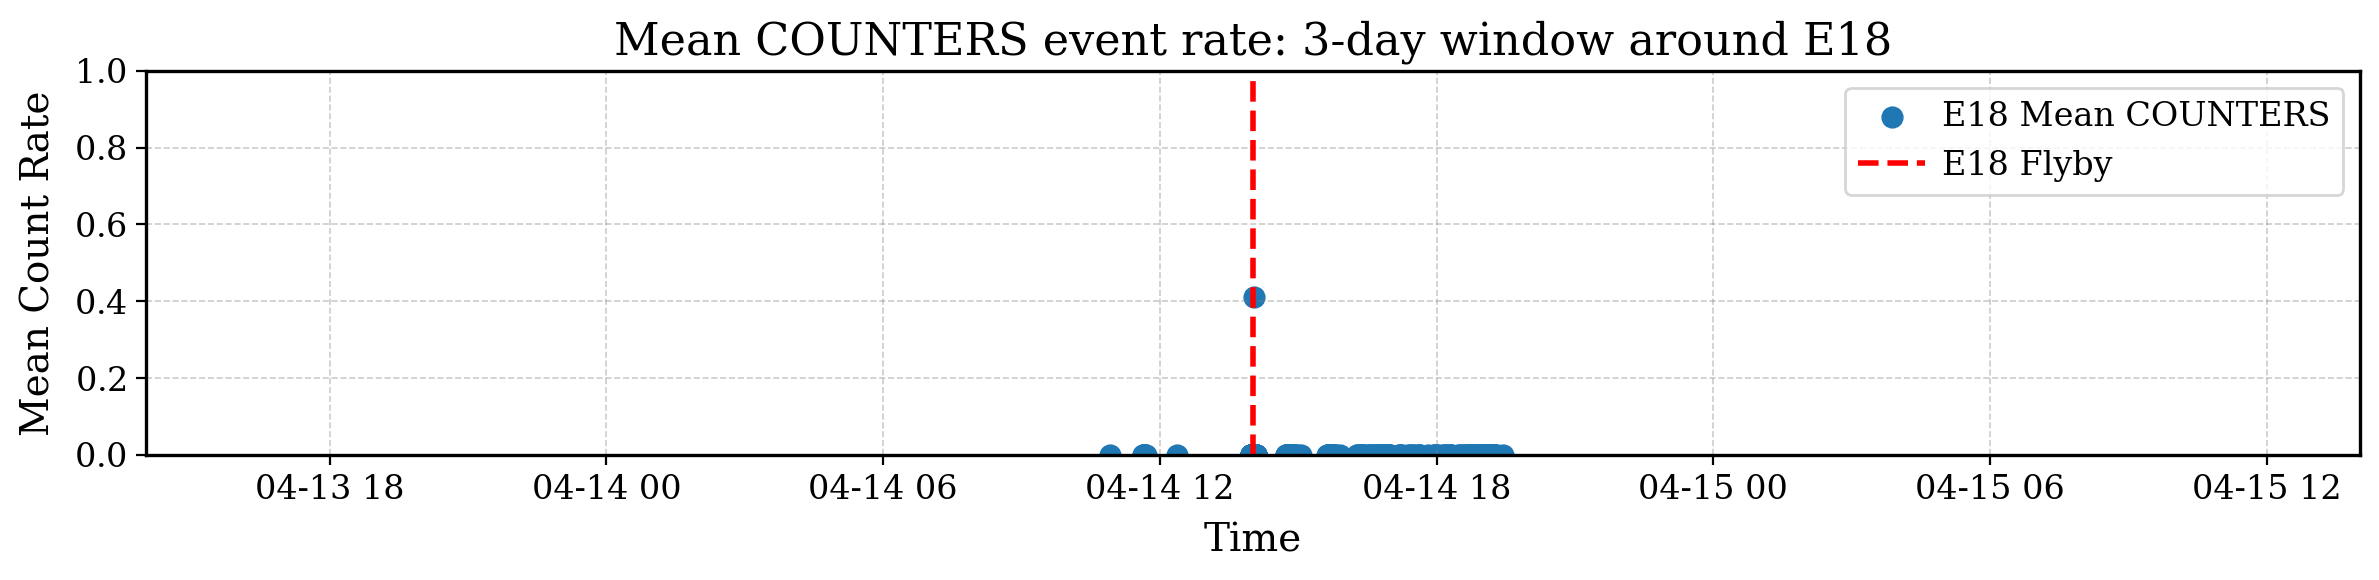

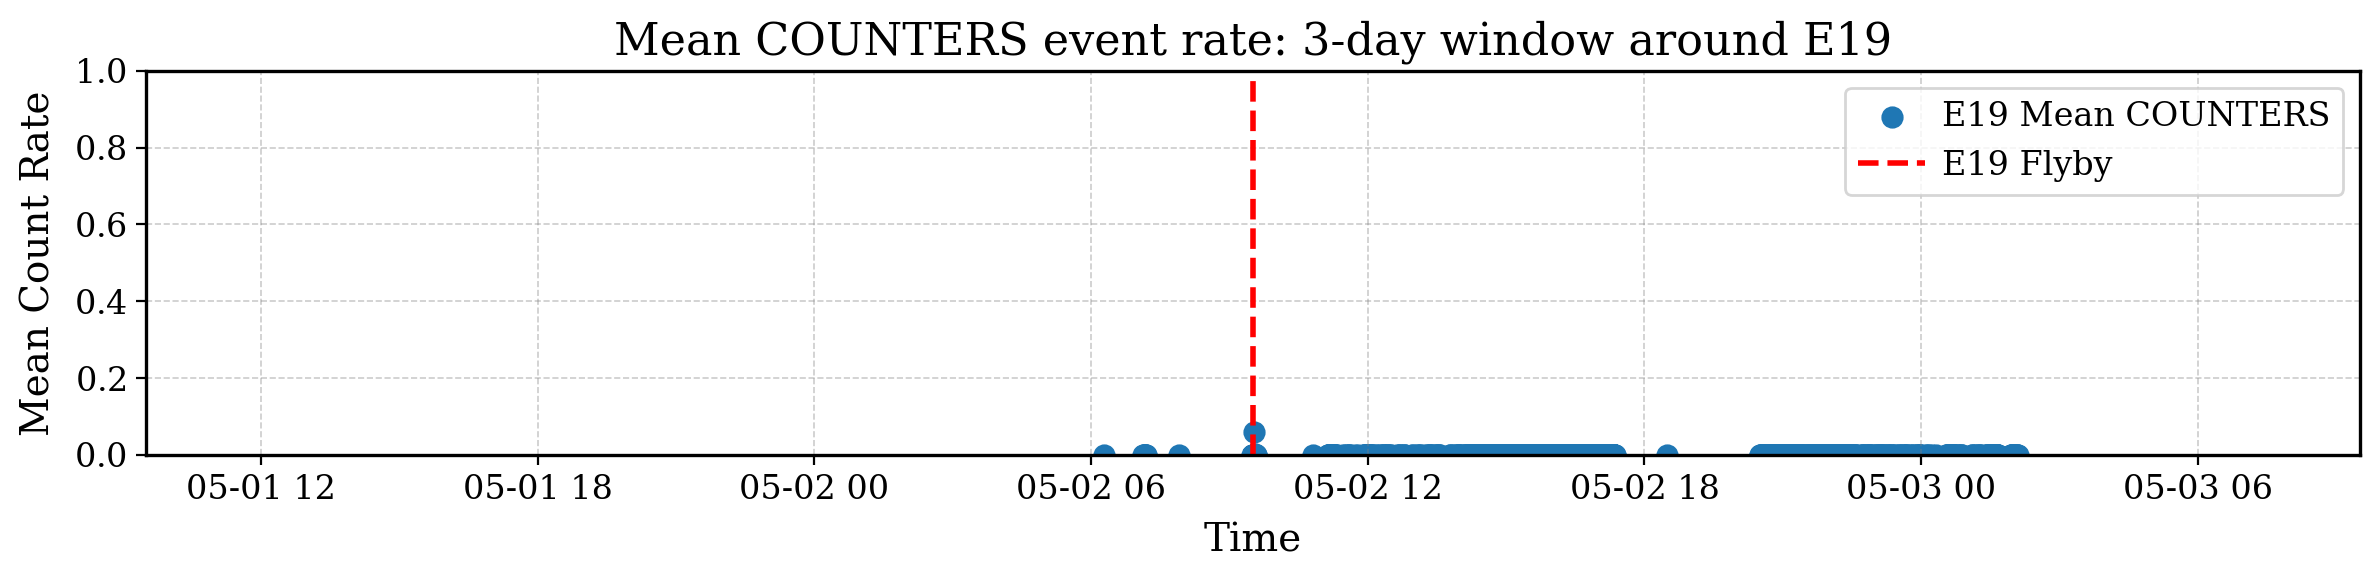

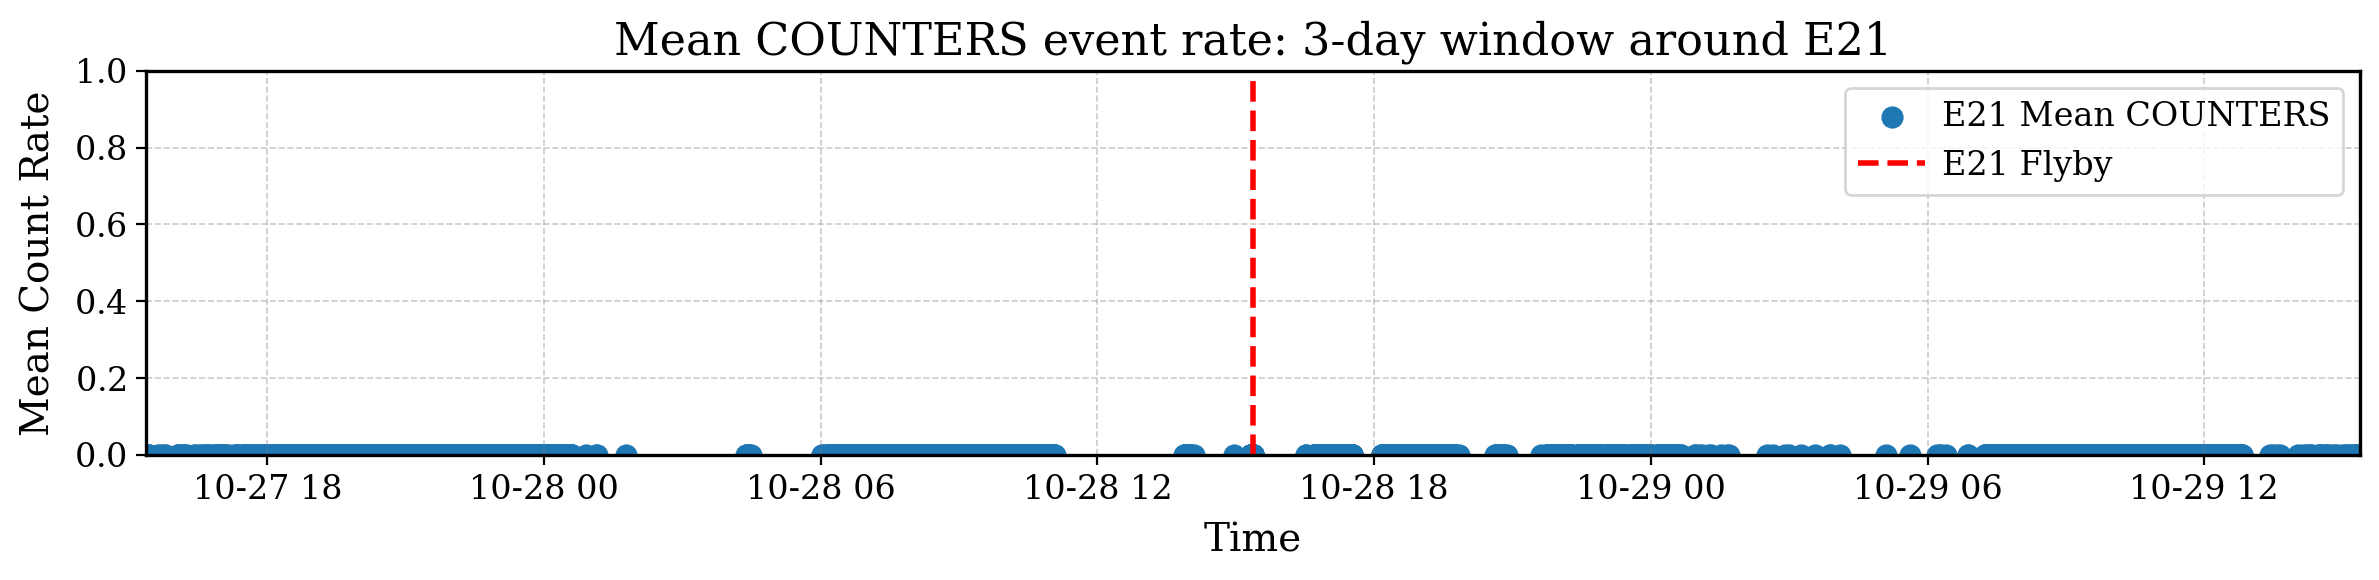

In [21]:
for name, t_flyby in flyby_times:
    start = t_flyby - pd.Timedelta(days=1)
    end = t_flyby + pd.Timedelta(days=1)
    # Filter data across all volumes for the 3-day window
    window_data = df_new[(df_new["TIME"] >= start) & (df_new["TIME"] <= end)]
    if window_data.empty:
        continue
    mean_rate = window_data[counter_cols].mean(axis=1)
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.scatter(window_data["TIME"], mean_rate, label=f"{name} Mean COUNTERS")
    ax.set_xlim(start, end)
    ax.set_ylim(0, 1)
    ax.axvline(t_flyby, color='red', linestyle='--', label=f"{name} Flyby")
    ax.set_title(f"Mean COUNTERS event rate: 3-day window around {name}")
    ax.set_ylabel("Mean Count Rate")
    ax.legend(loc="upper right")
    plt.xlabel("Time")
    plt.tight_layout()
    plt.show()

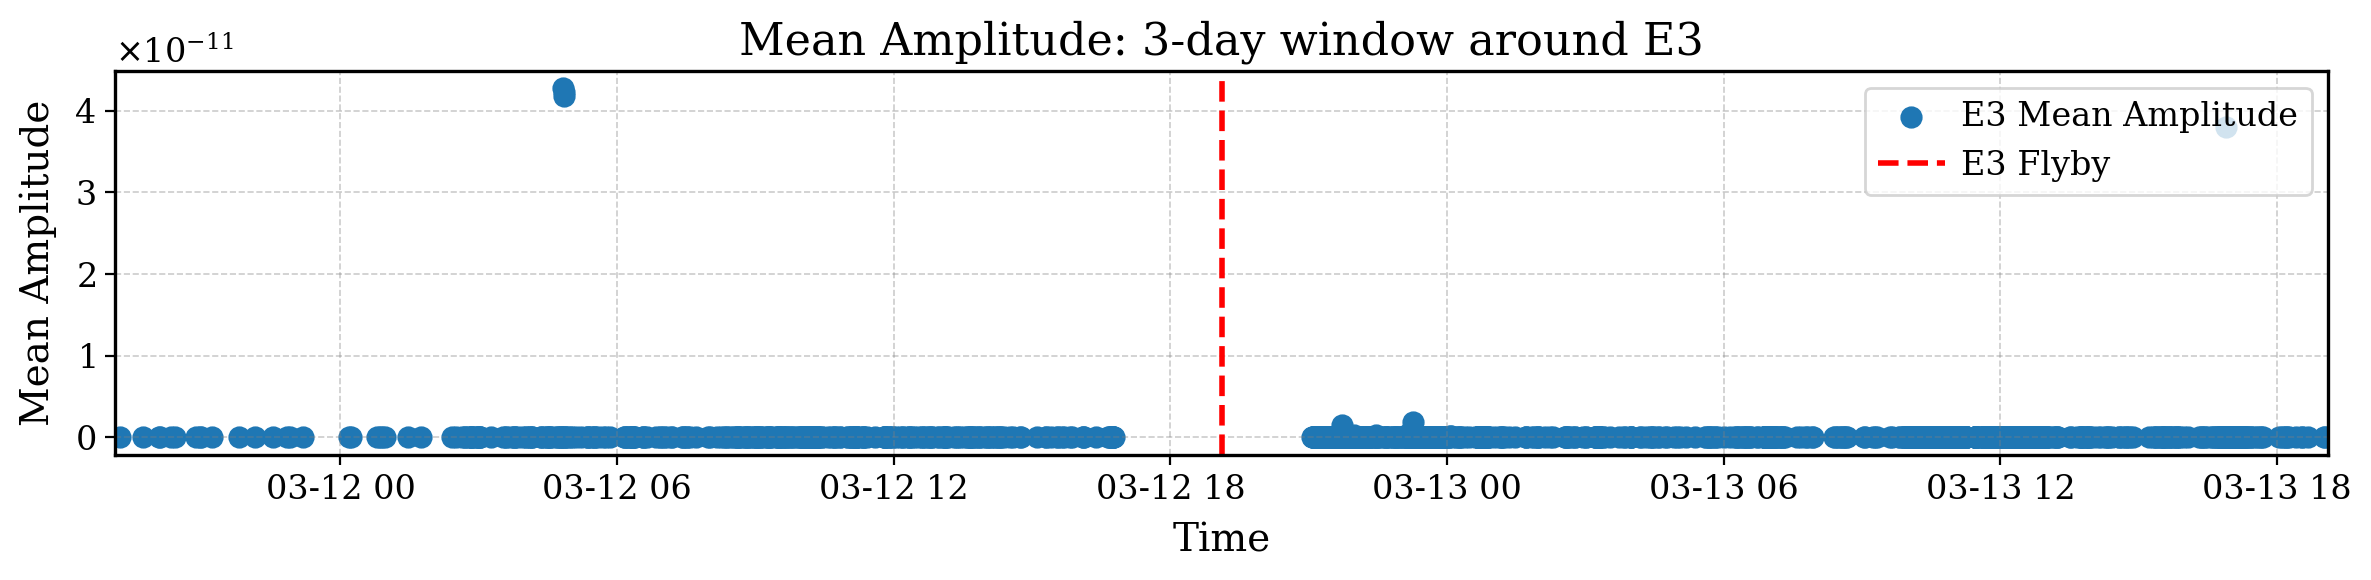

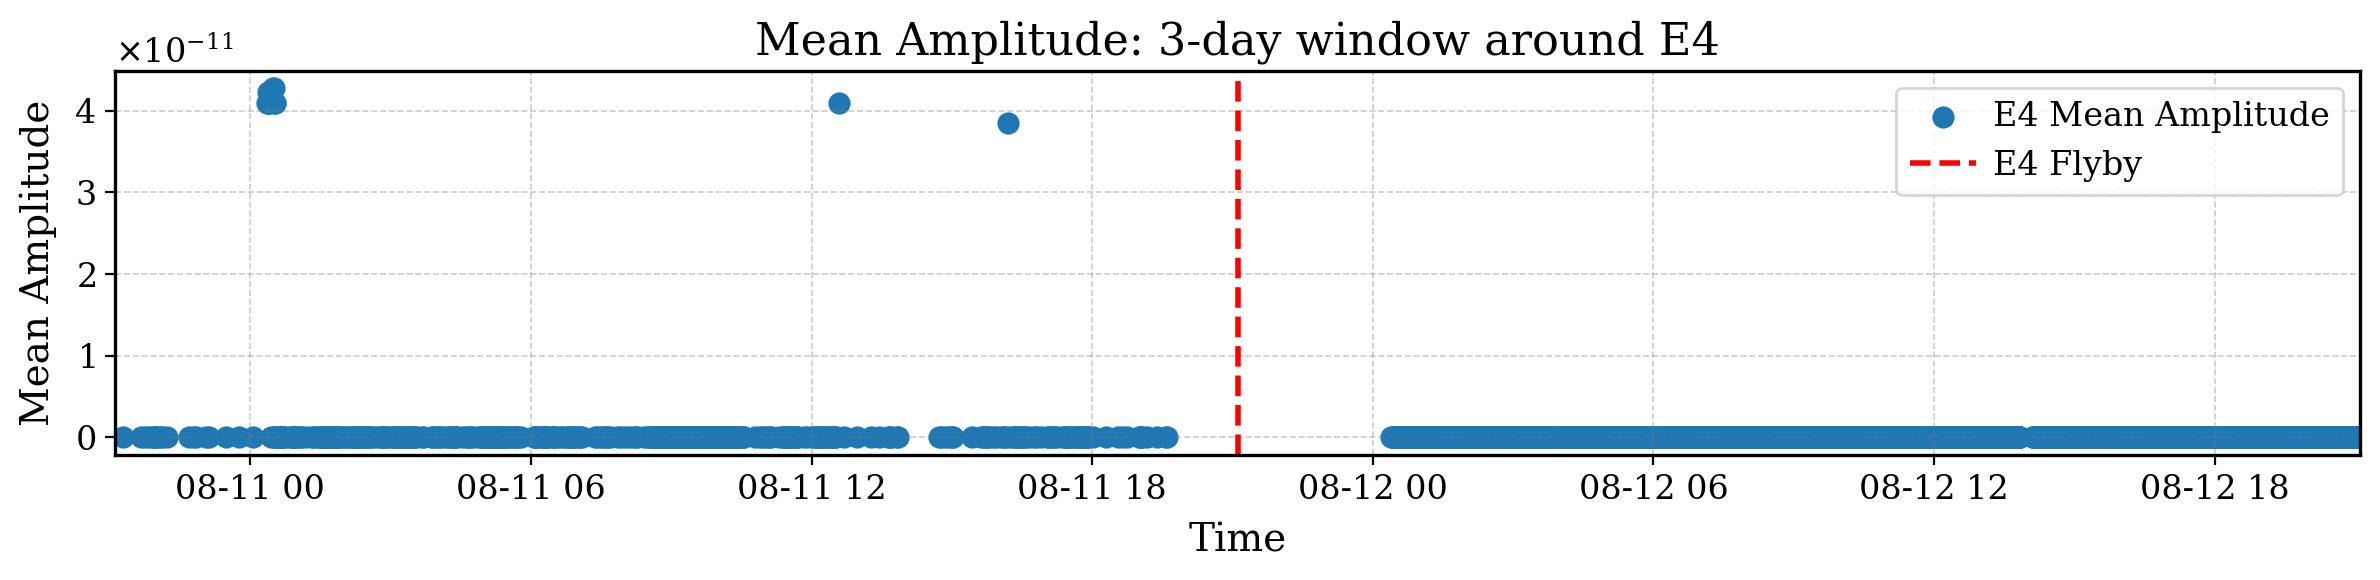

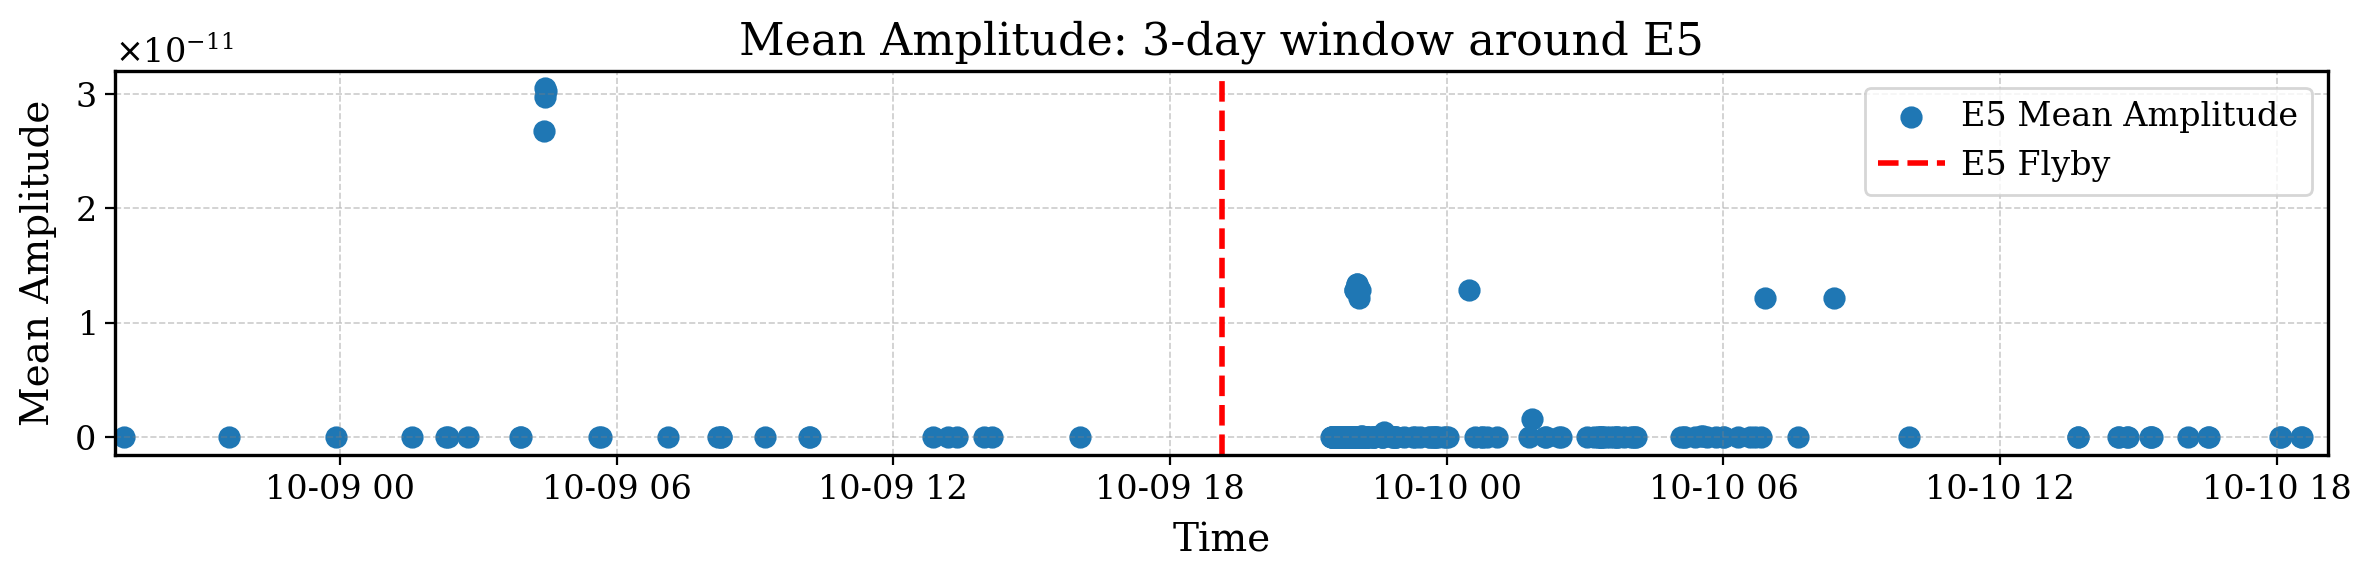

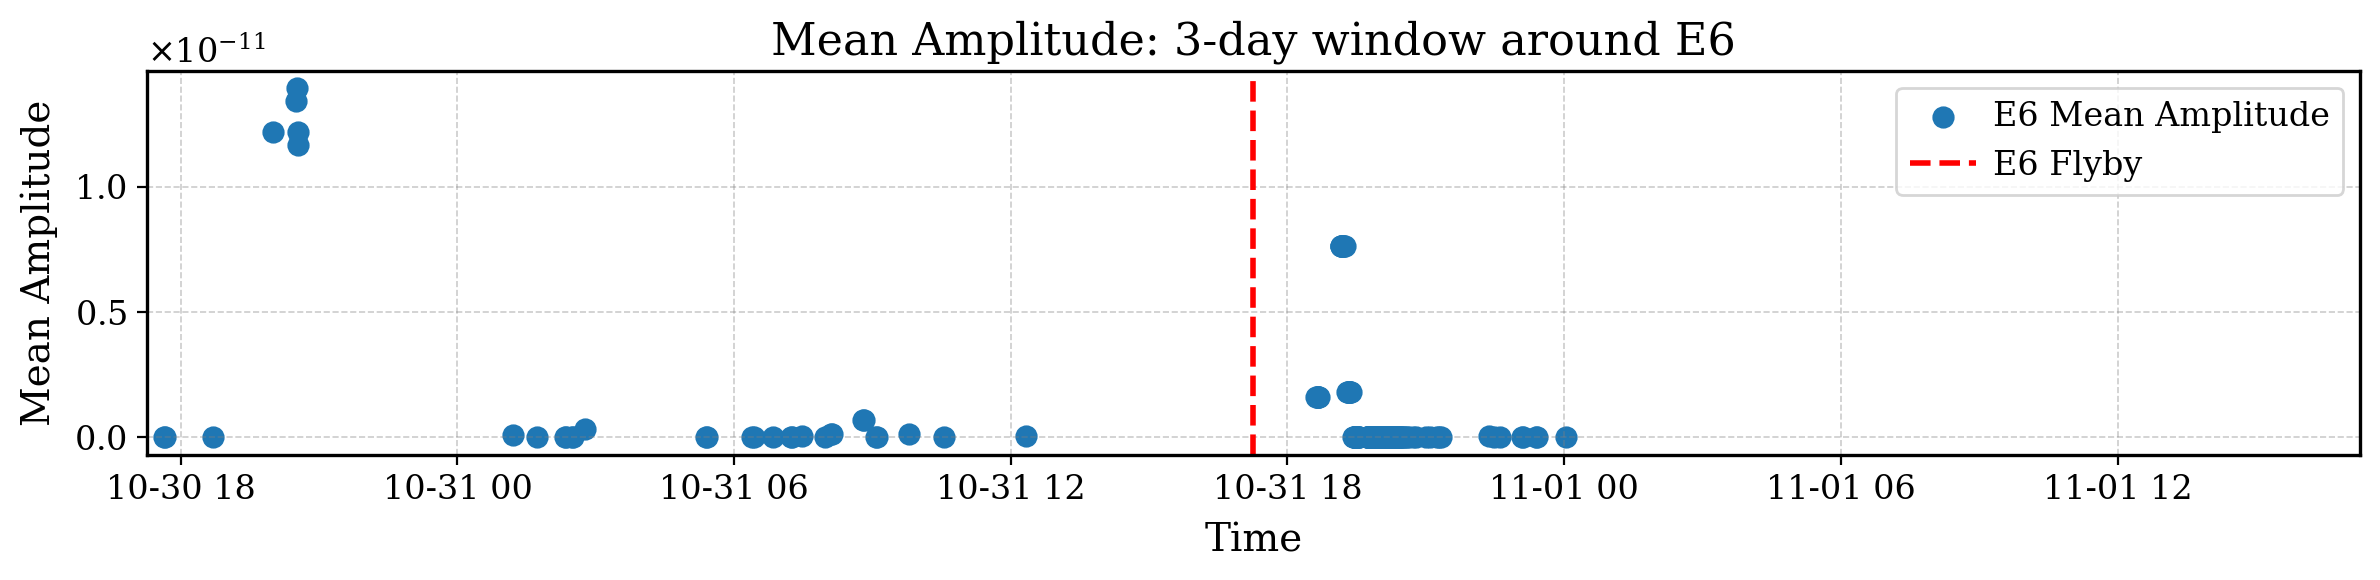

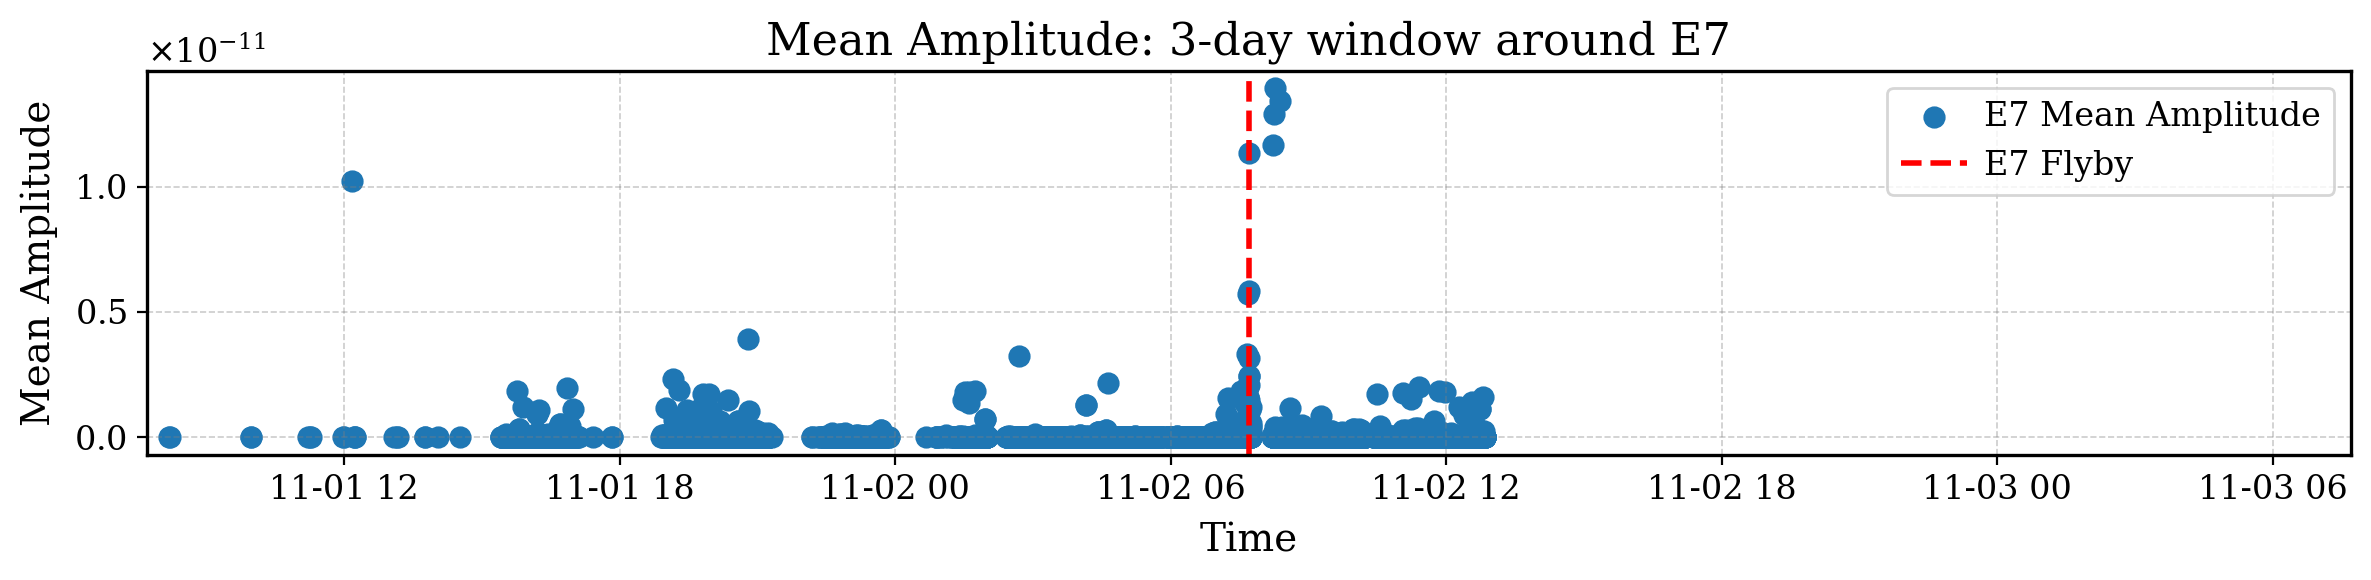

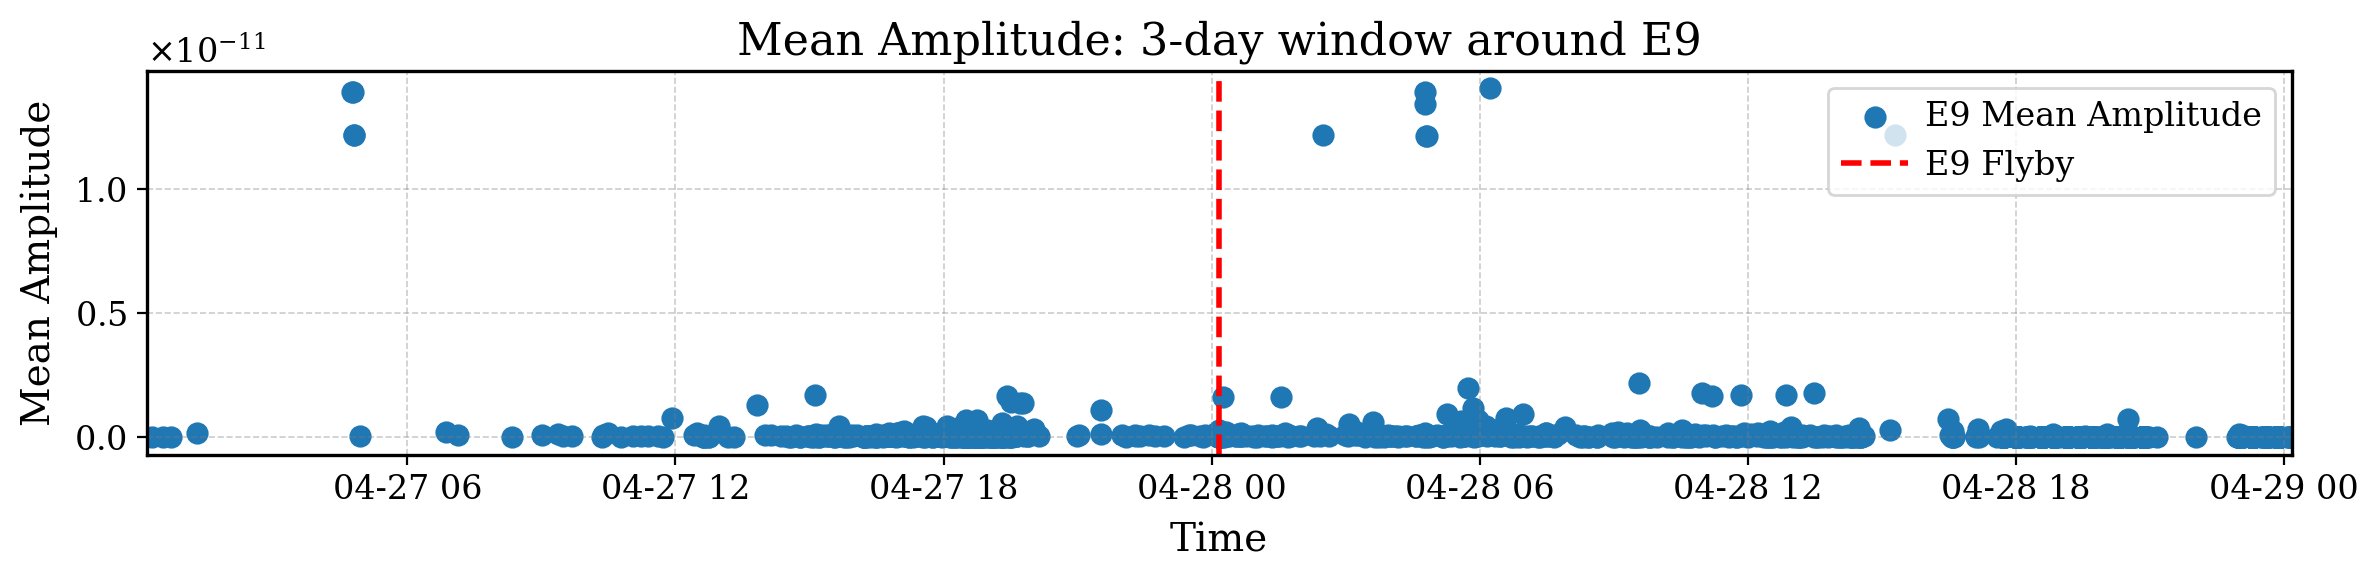

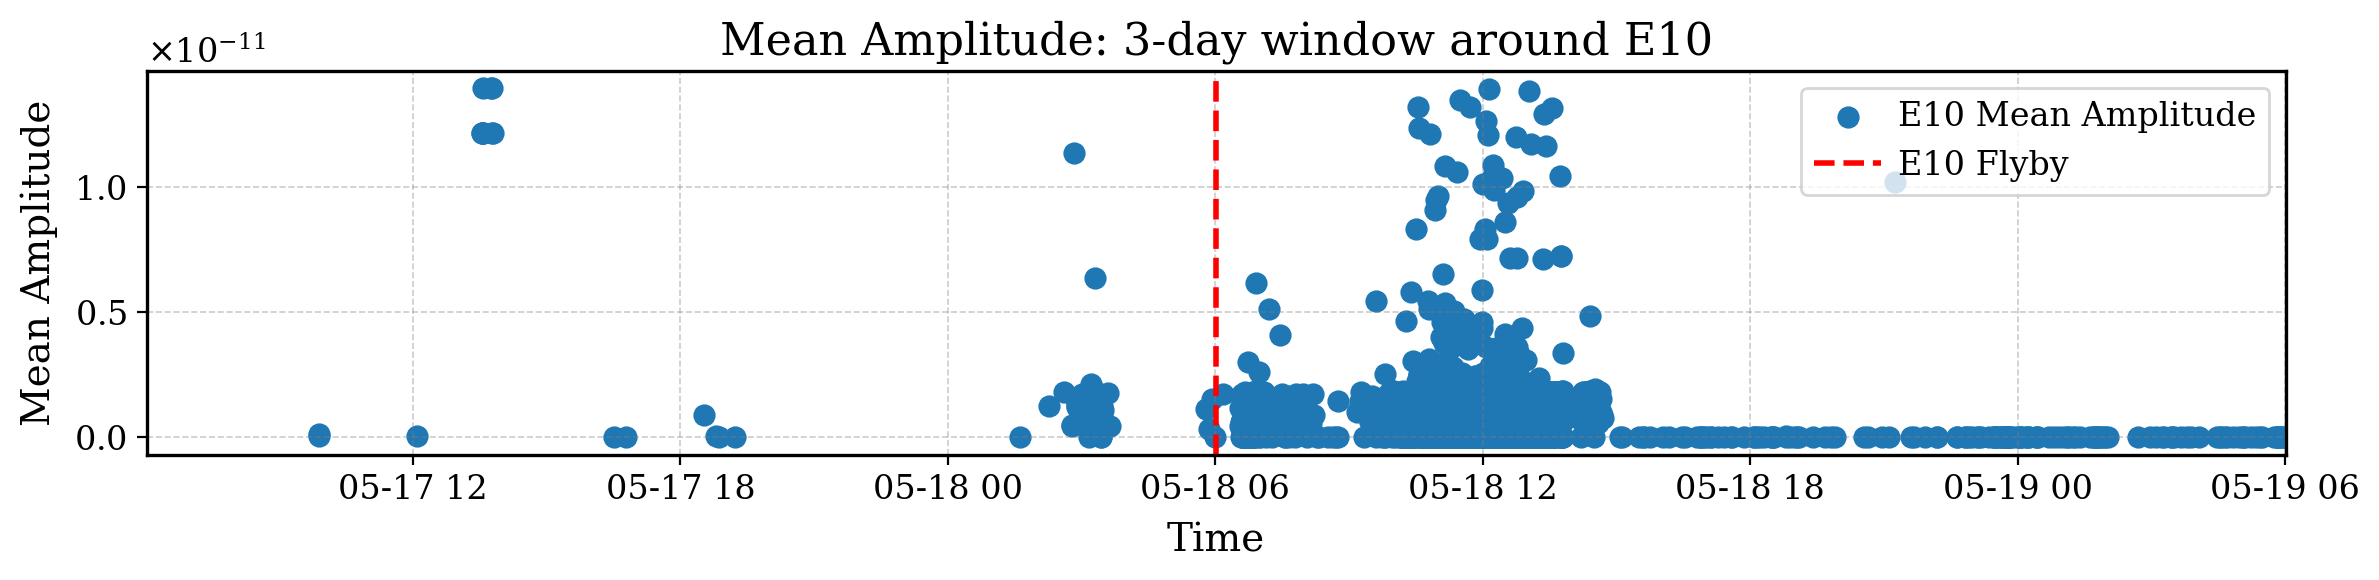

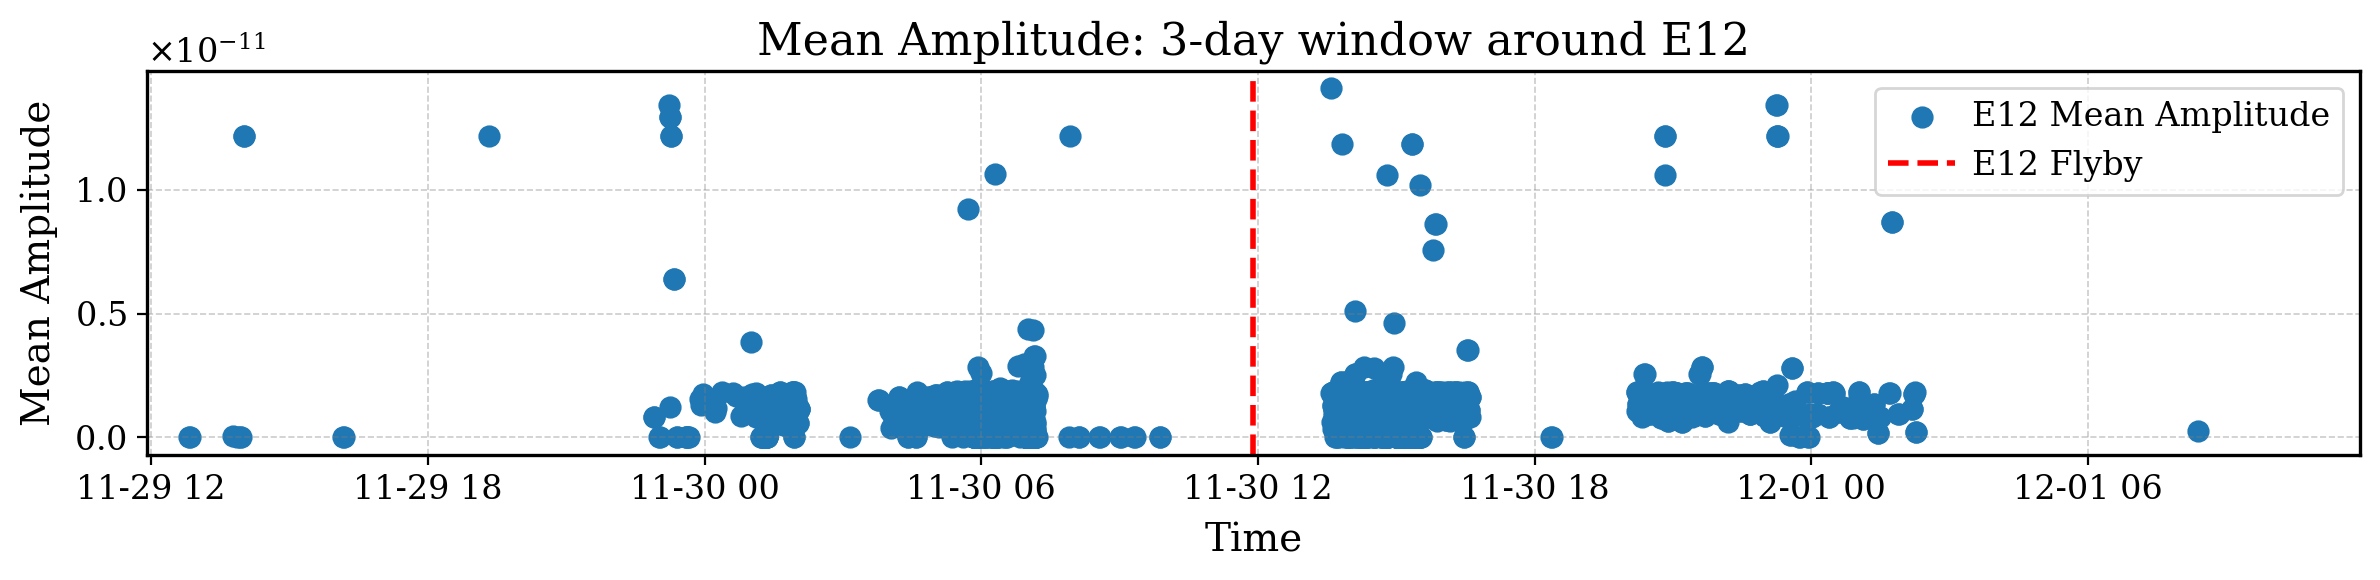

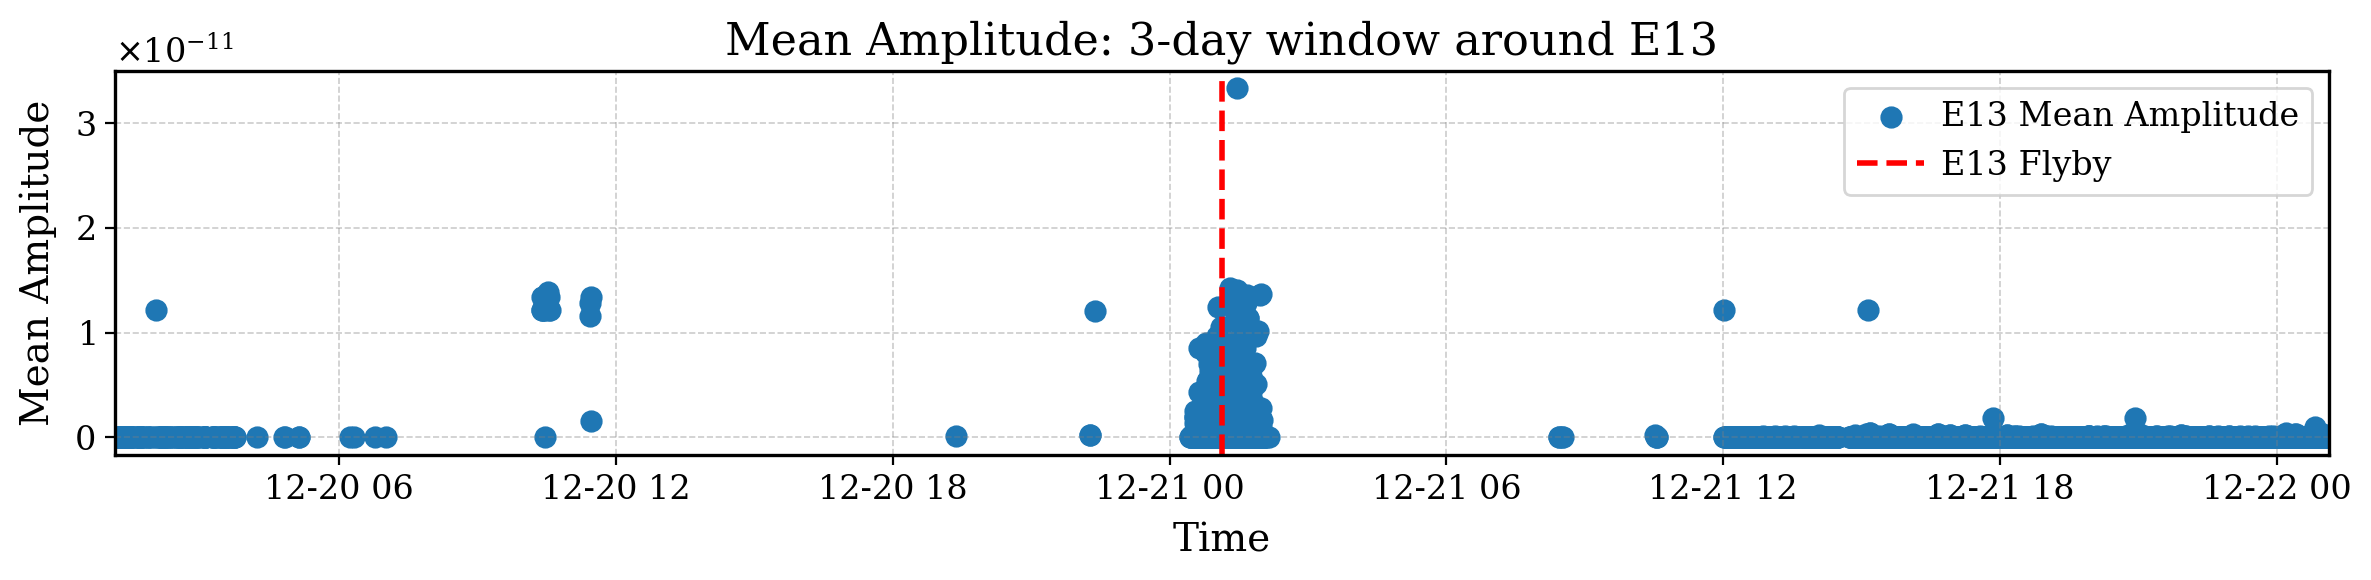

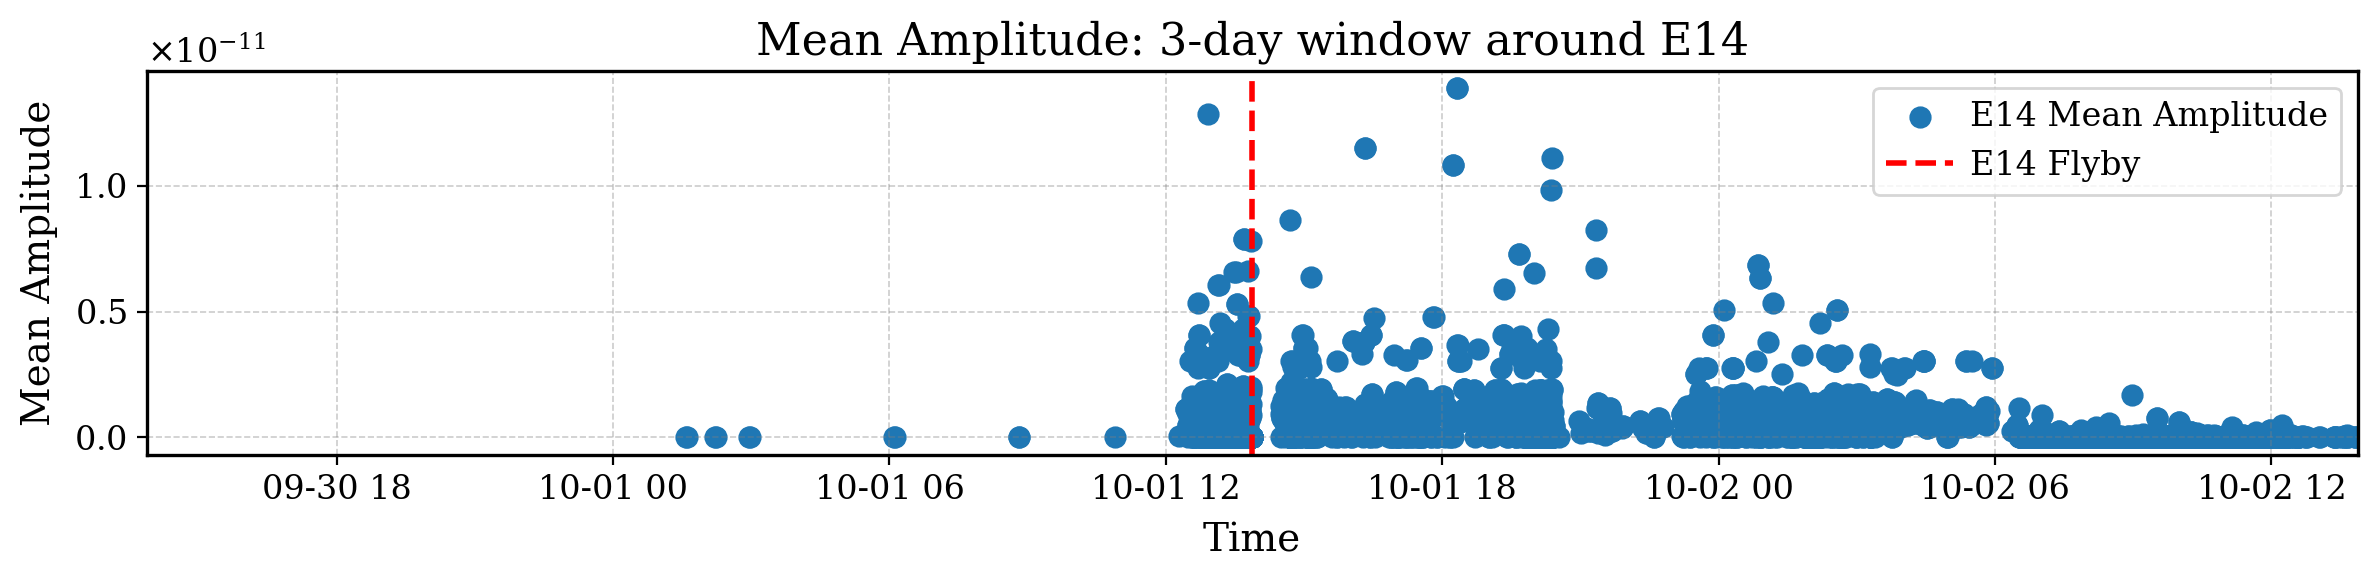

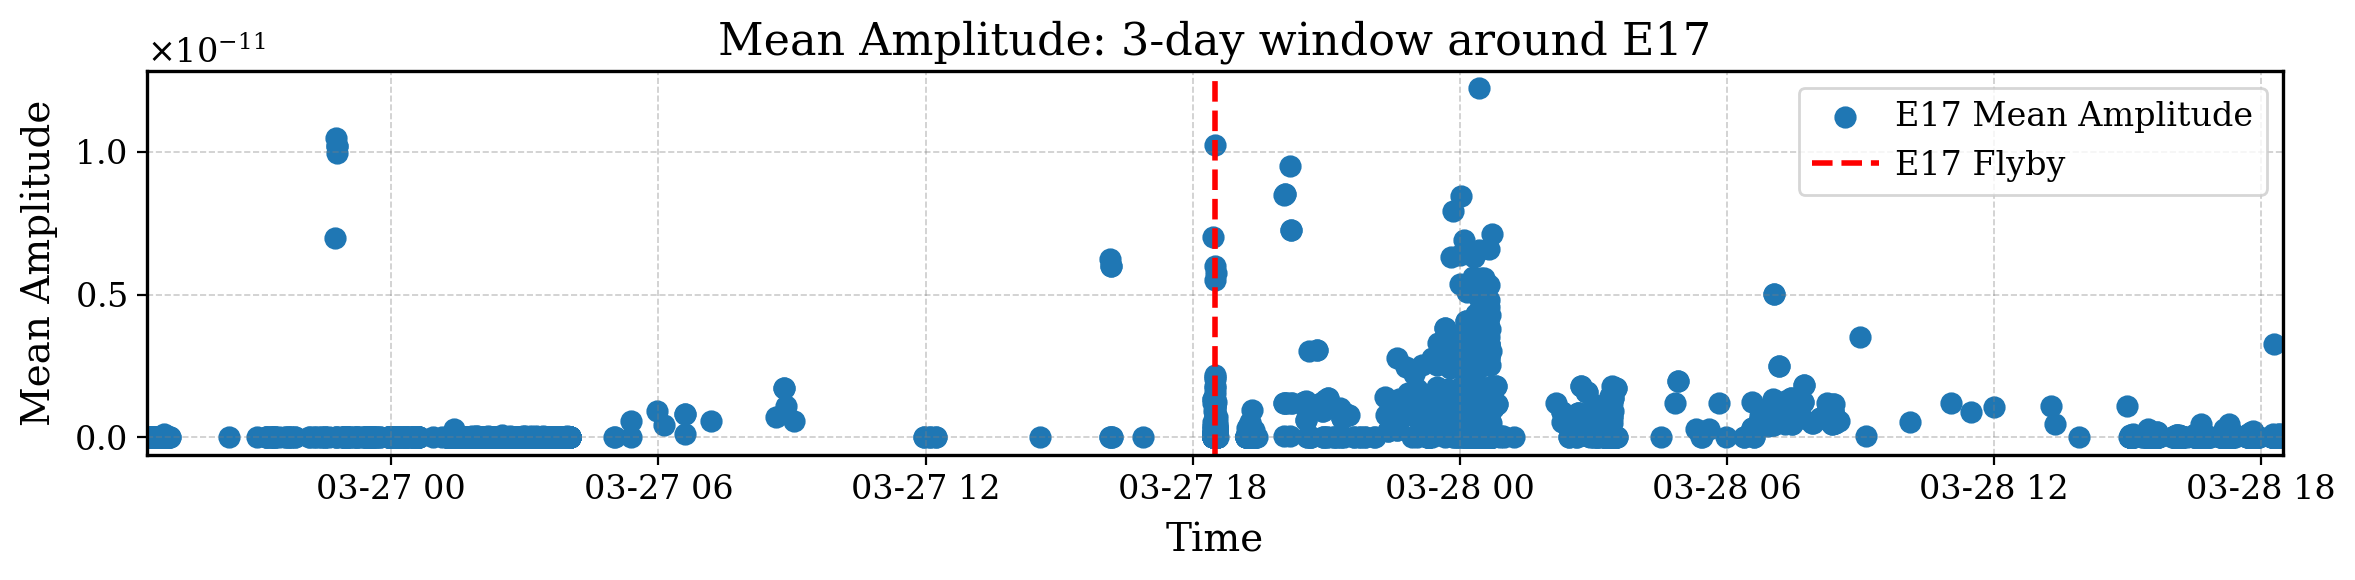

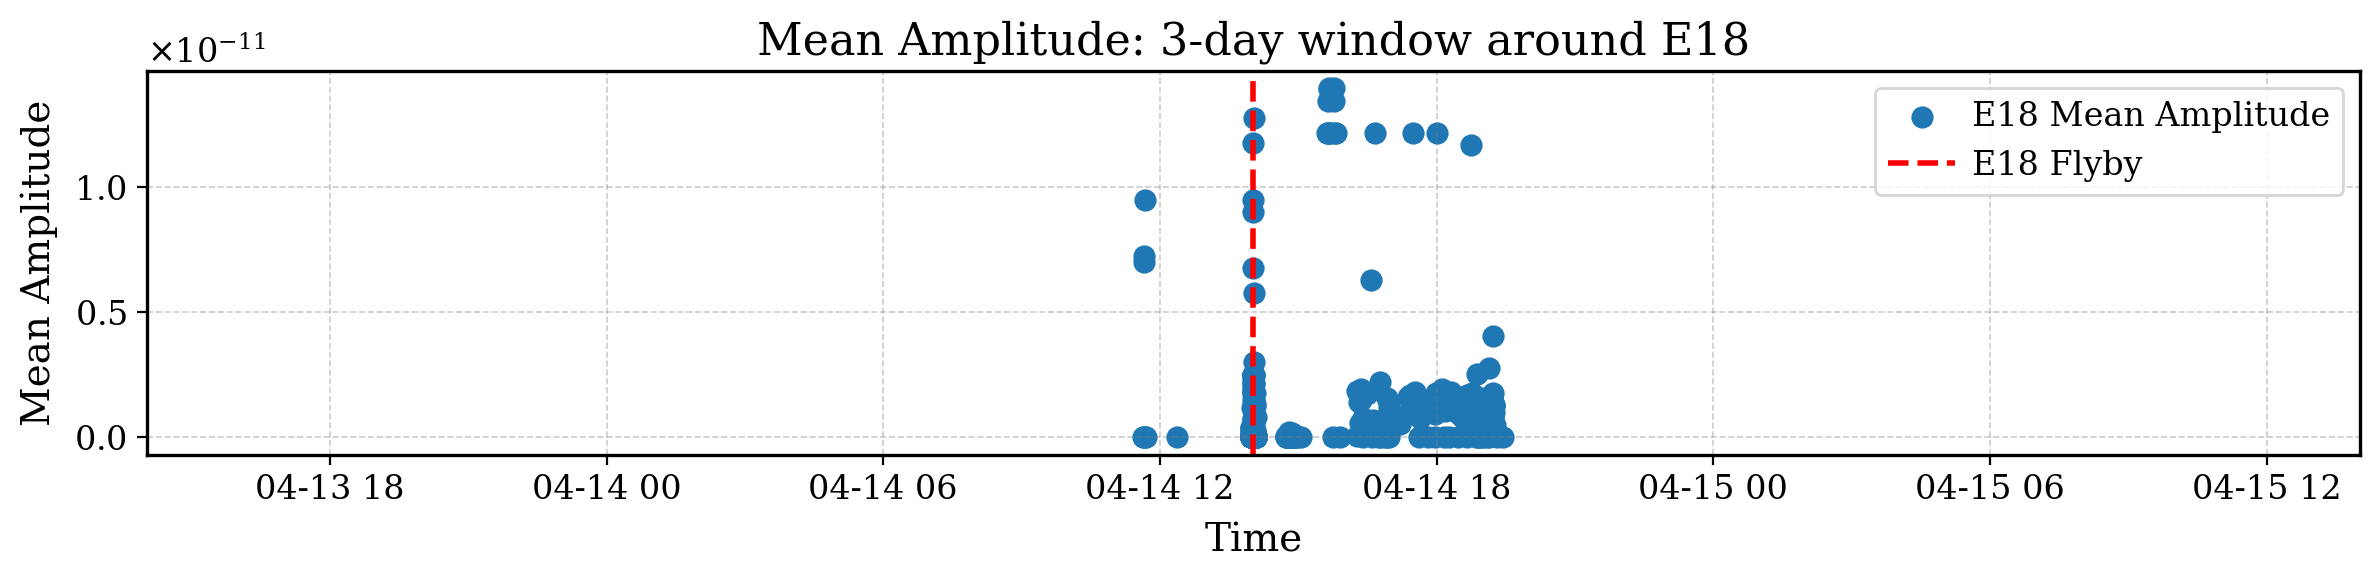

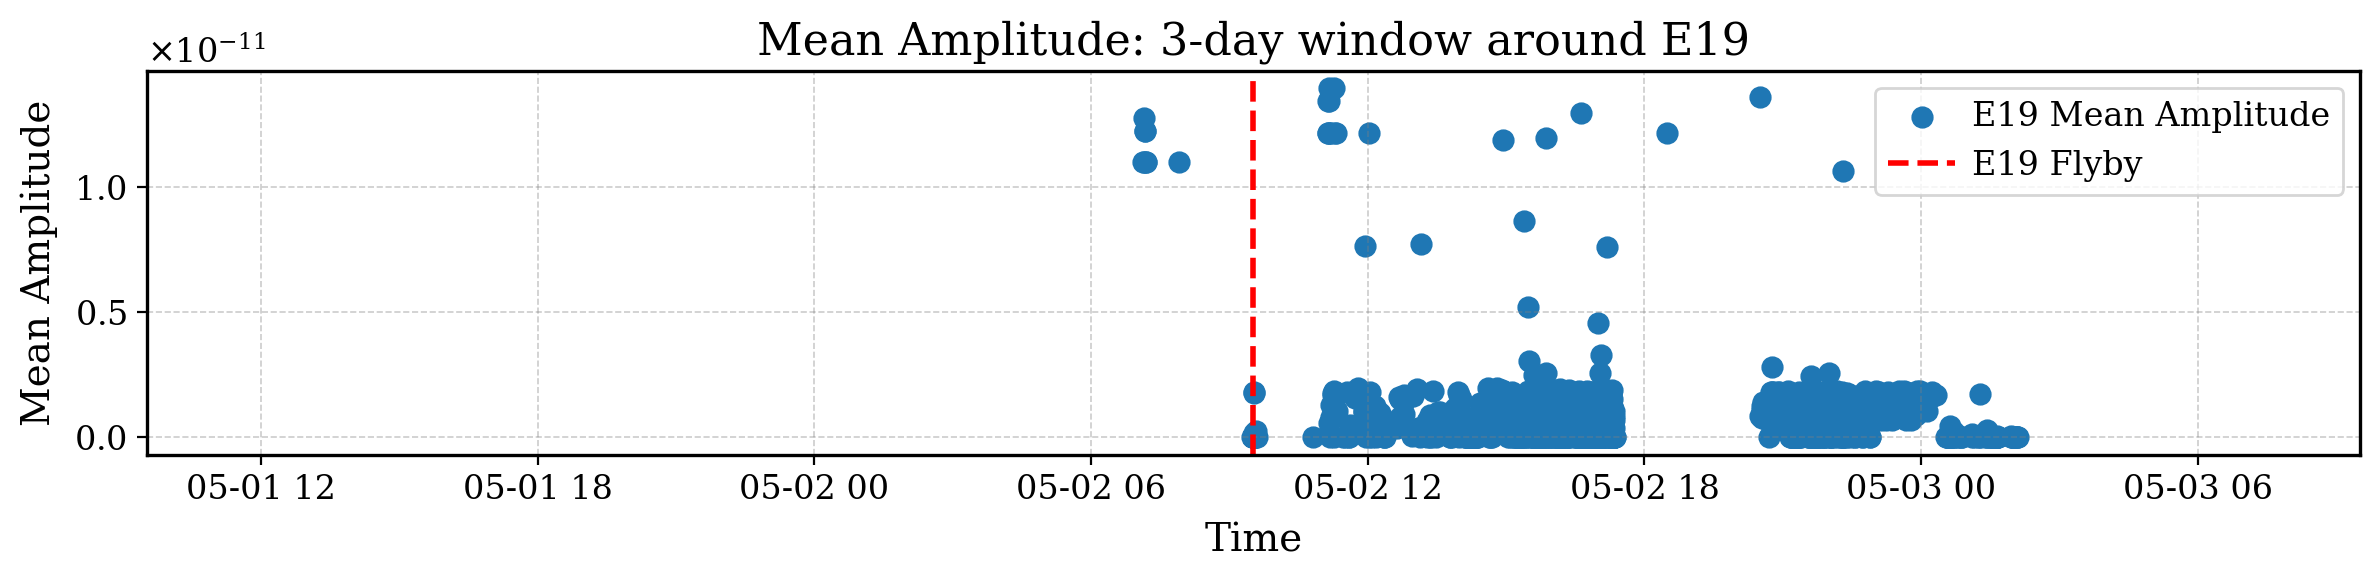

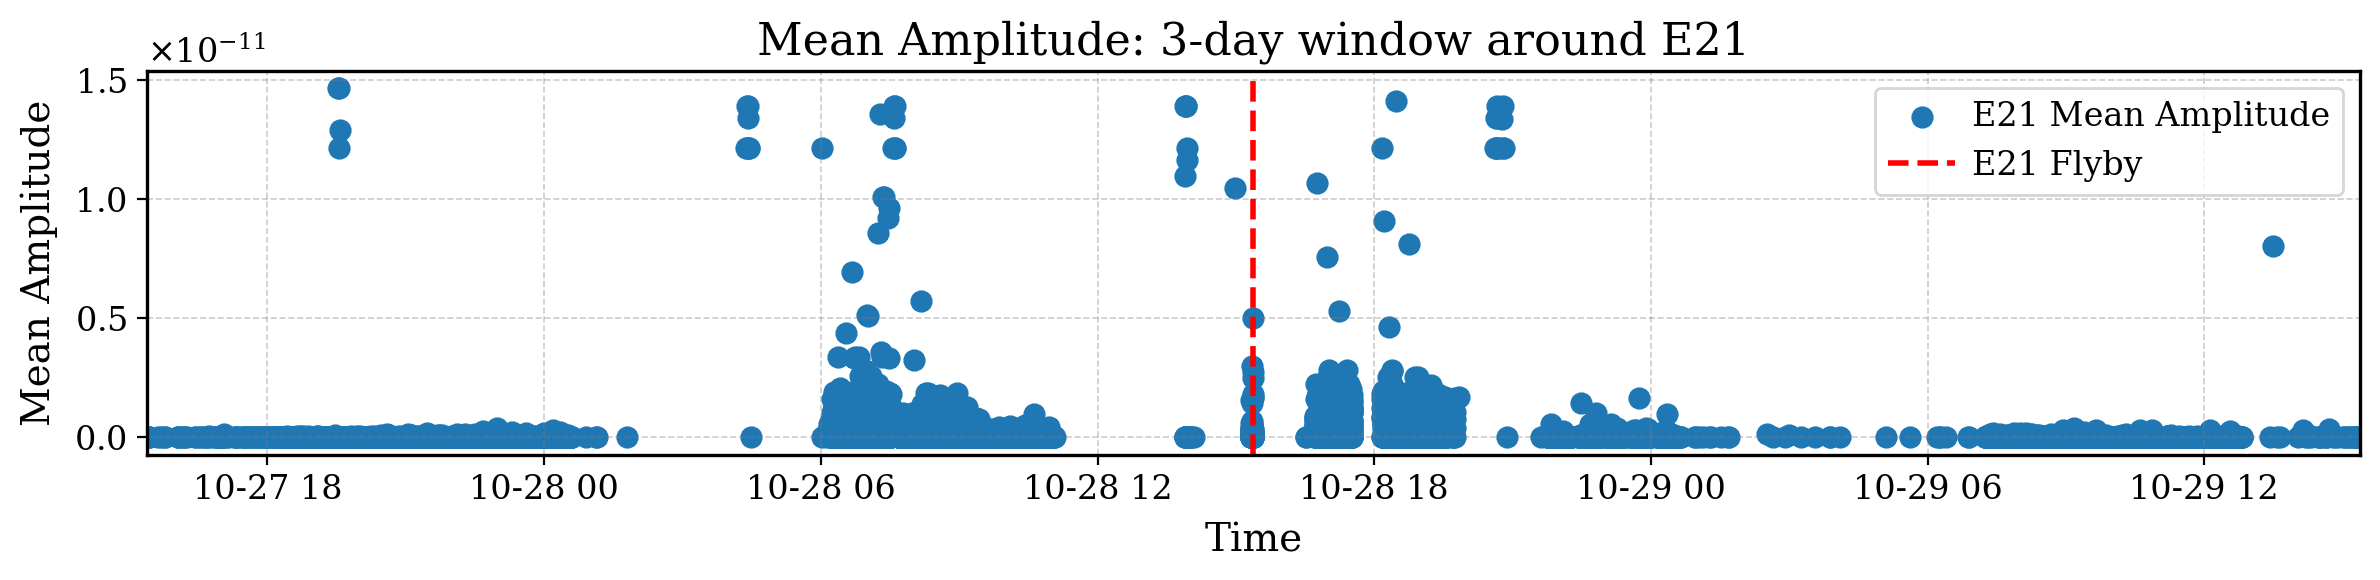

In [22]:
for name, t_flyby in flyby_times:
    start = t_flyby - pd.Timedelta(days=1)
    end = t_flyby + pd.Timedelta(days=1)
    window_data = df_new[(df_new["TIME"] >= start) & (df_new["TIME"] <= end)]
    if window_data.empty:
        continue
    mean_amp = window_data[amplitude_cols].mean(axis=1)
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.scatter(window_data["TIME"], mean_amp, label=f"{name} Mean Amplitude")
    ax.set_xlim(start, end)
    ax.axvline(t_flyby, color='red', linestyle='--', label=f"{name} Flyby")
    ax.set_title(f"Mean Amplitude: 3-day window around {name}")
    ax.set_ylabel("Mean Amplitude")
    ax.legend(loc="upper right")
    plt.xlabel("Time")
    plt.tight_layout()
    plt.show()